# DAA Based LASSO Analysis

In [ ]:
import os
os.chdir('../')

Loading data...
CD data shape: (155, 3296)
UC data shape: (96, 3296)
Number of CD metabolic features: 3293
Number of UC metabolic features: 3293
Number of common metabolic features: 3293

LASSO Feature Selection for CD and UC

Performing LASSO feature selection for CD clusters...
Best C value: 0.233572
LASSO selected 42 features with non-zero coefficients

Selected 42 features for CD
Top 10 CD features by LASSO coefficient magnitude:
              feature  coefficient
419   C18n_QI4450__NA     0.470482
1945  HILn_QI1410__NA     0.225557
706   C18n_QI1942__NA     0.221190
581    C18n_QI804__NA     0.178551
2990  HILp_QI3825__NA     0.178274
2717  HILp_QI2036__NA     0.166338
2431  HILp_QI7795__NA     0.161213
1966  HILn_QI1552__NA     0.159270
158   C18n_QI3676__NA     0.137595
371   C18n_QI2043__NA     0.131729

Performing LASSO feature selection for UC clusters...
Best C value: 0.233572
LASSO selected 19 features with non-zero coefficients

Selected 19 features for UC
Top 10 UC featur

<Figure size 3000x1400 with 0 Axes>

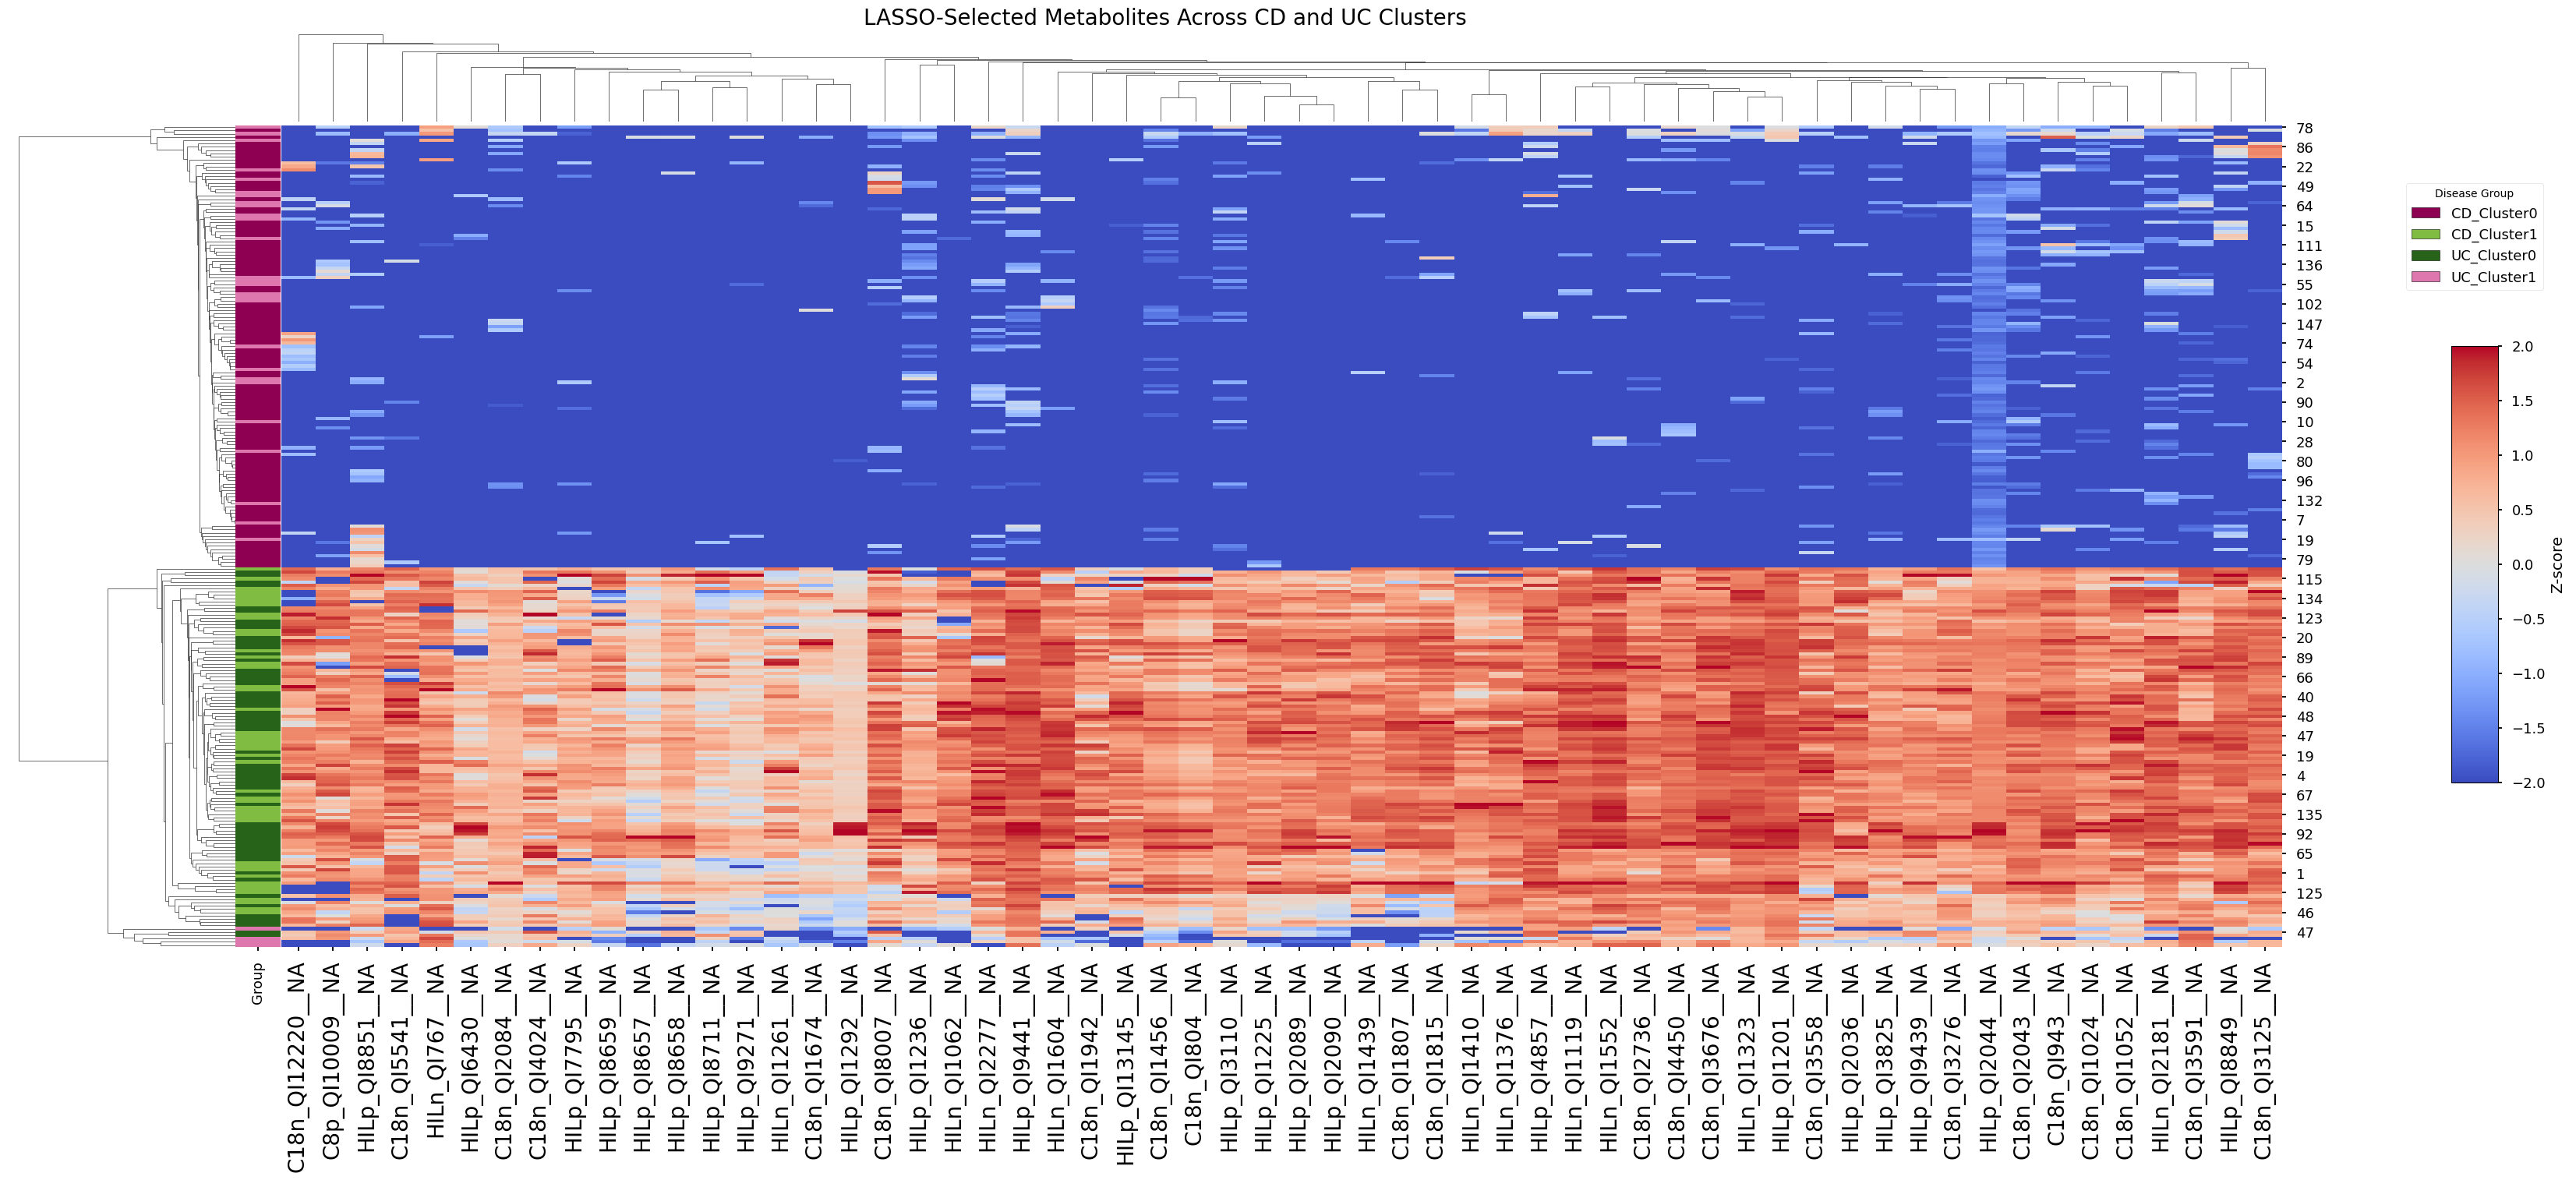

Full feature names saved to: data/lasso_selected_features_names.tsv

Full list of selected features:
1. C18n_QI1024__NA
2. HILp_QI1236__NA
3. HILn_QI1439__NA
4. HILn_QI1062__NA
5. HILn_QI767__NA
6. HILn_QI1604__NA
7. C18n_QI4450__NA
8. HILn_QI1410__NA
9. HILp_QI9439__NA
10. C18n_QI3558__NA
11. HILn_QI1376__NA
12. HILn_QI1119__NA
13. HILp_QI2036__NA
14. HILn_QI1323__NA
15. HILp_QI8711__NA
16. C18n_QI1052__NA
17. HILp_QI3110__NA
18. HILp_QI7795__NA
19. HILp_QI2044__NA
20. C18n_QI1807__NA
21. C18n_QI2084__NA
22. HILn_QI1261__NA
23. C18n_QI3276__NA
24. C18n_QI1674__NA
25. HILp_QI1201__NA
26. C18n_QI1942__NA
27. C18n_QI2736__NA
28. HILp_QI1292__NA
29. C18n_QI1815__NA
30. HILn_QI1552__NA
31. C18n_QI2043__NA
32. C18n_QI1456__NA
33. HILp_QI4857__NA
34. HILn_QI2181__NA
35. HILp_QI6430__NA
36. C18n_QI804__NA
37. C18n_QI5541__NA
38. C18n_QI3676__NA
39. C18n_QI3591__NA
40. HILp_QI13145__NA
41. HILn_QI2277__NA
42. C8p_QI10009__NA
43. HILp_QI9441__NA
44. HILp_QI8851__NA
45. HILp_QI9271__NA
46. HILp_

<Figure size 1200x800 with 0 Axes>

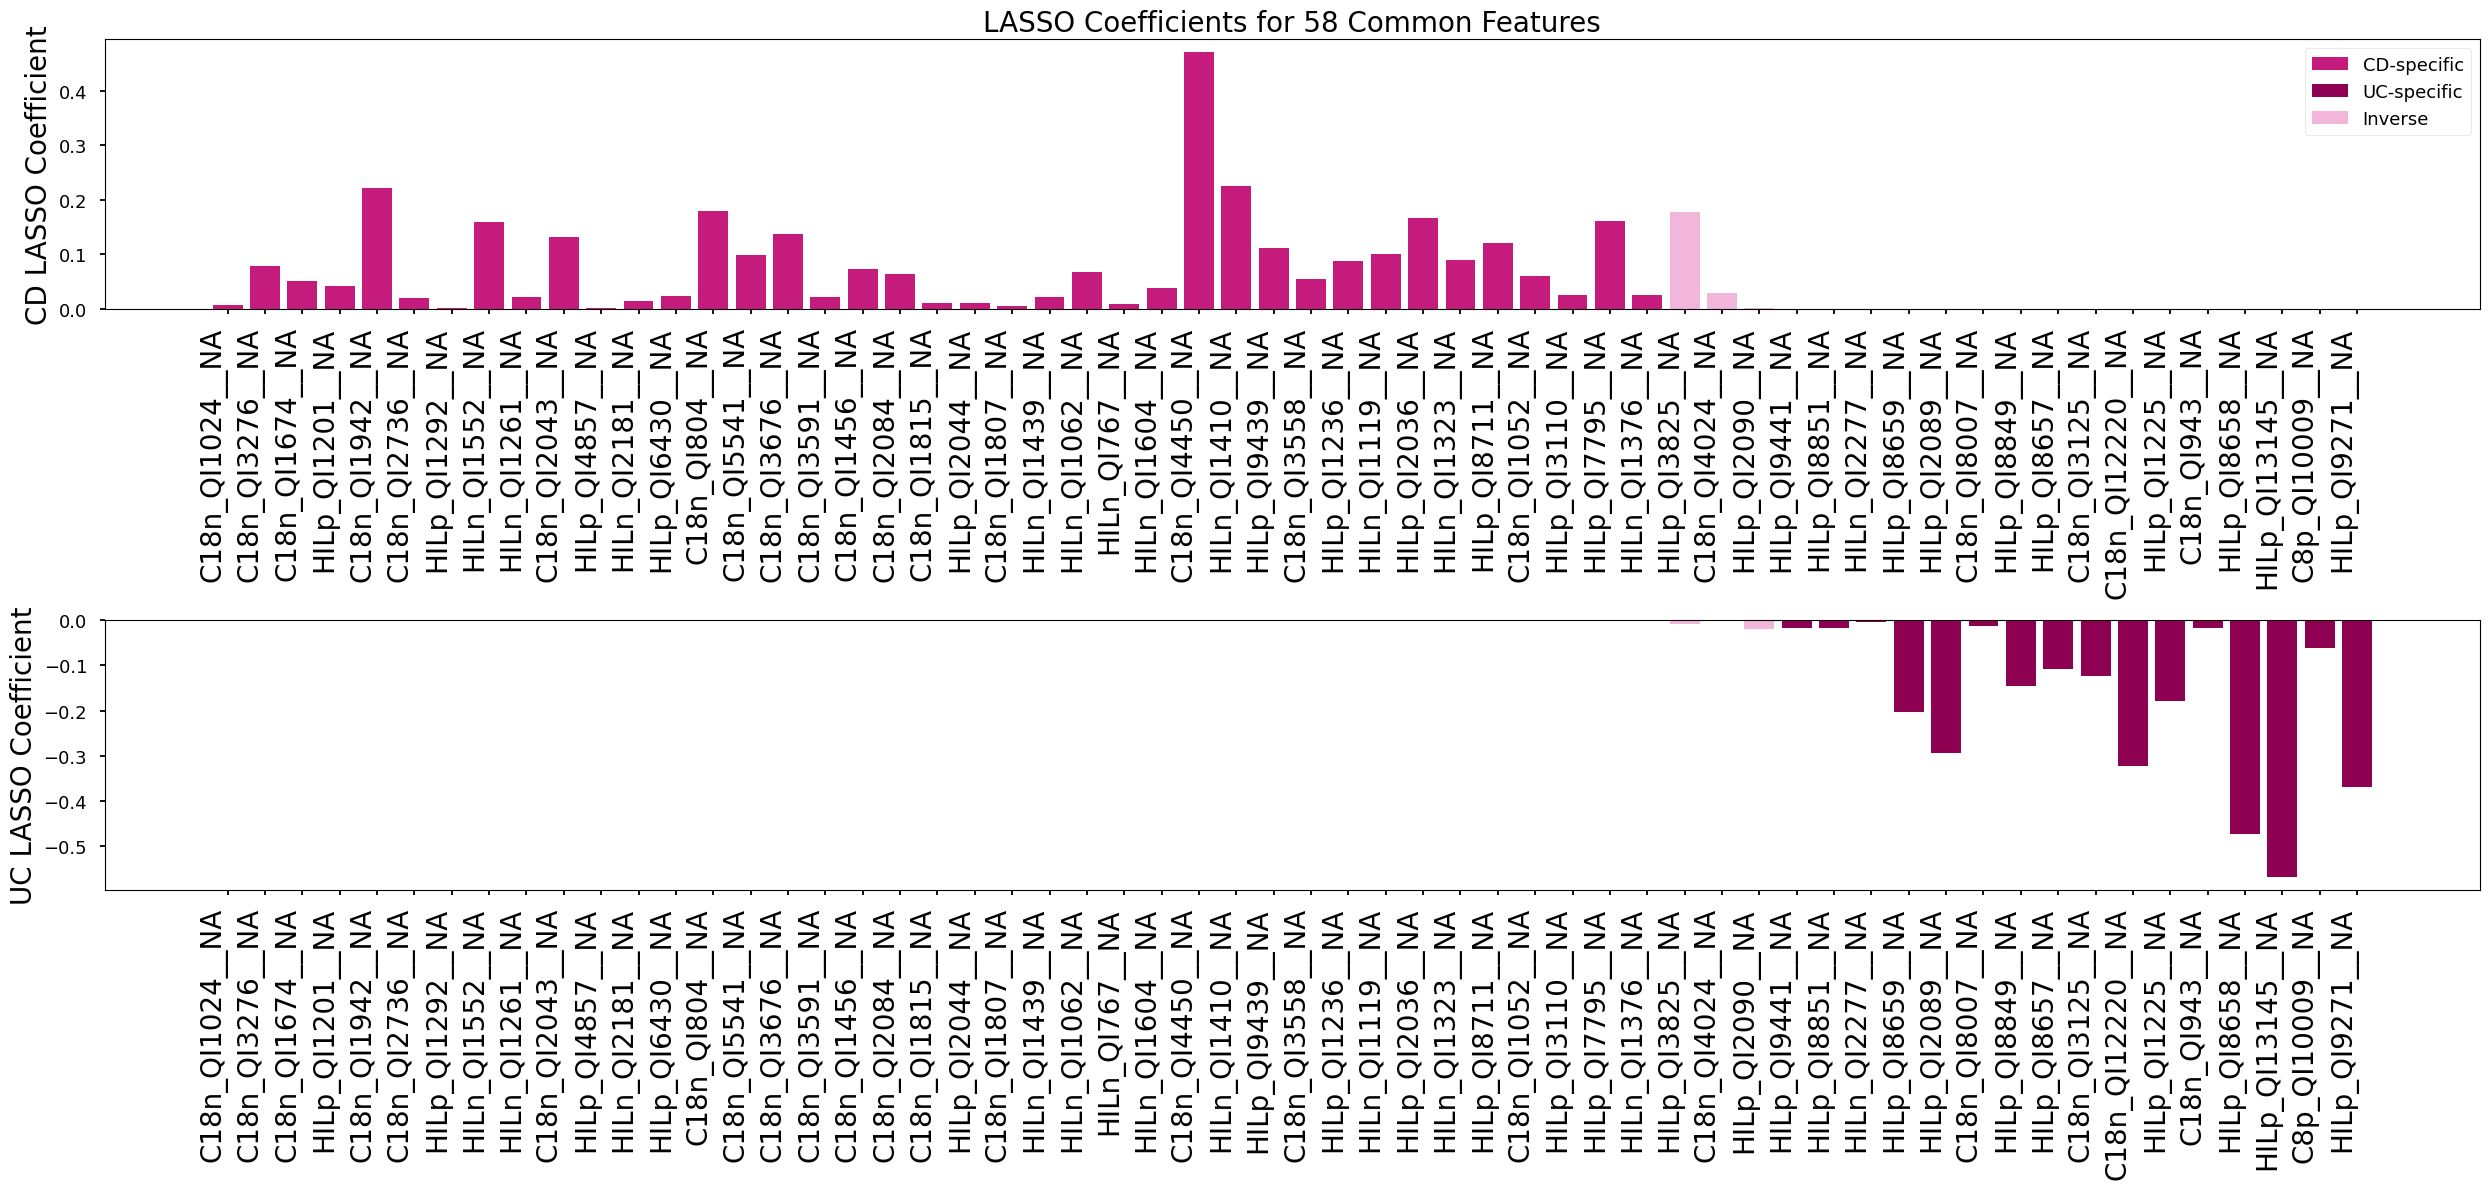

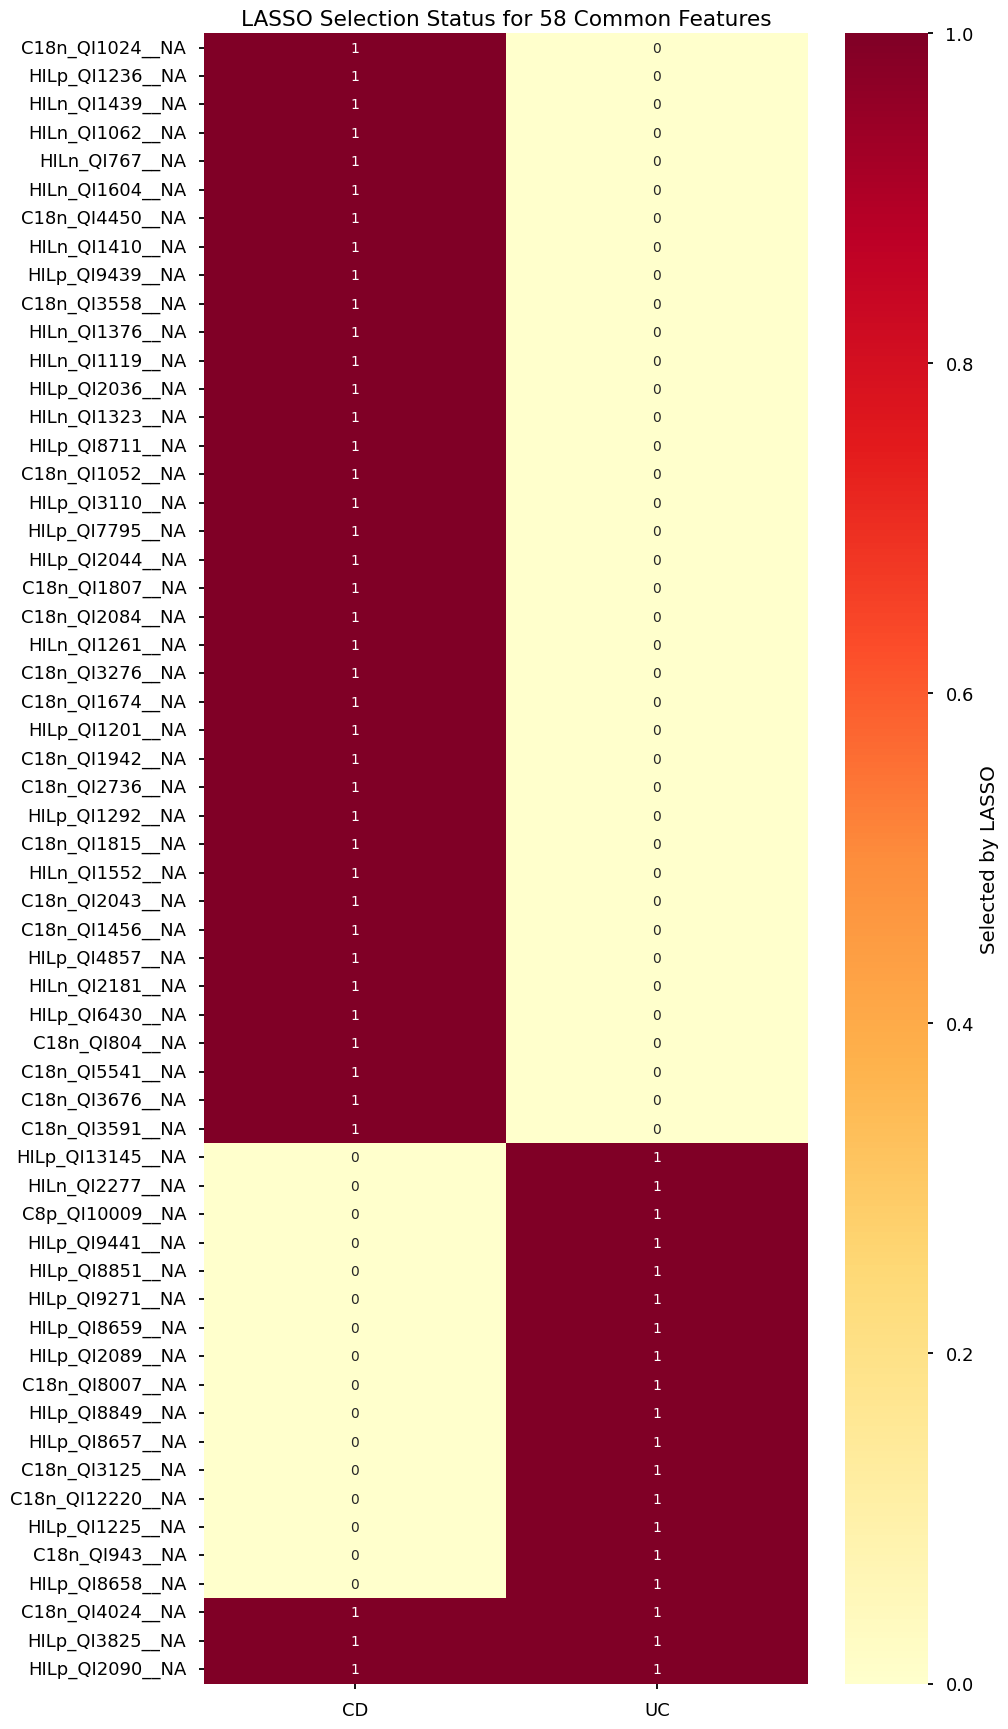


Detailed Analysis of Inverse Features

Feature: C18n_QI4024__NA
CD coefficient: 0.0294 (Cluster 1 higher than Cluster 0)
UC coefficient: -0.0000 (Cluster 1 lower than Cluster 0)
Interpretation: This metabolite shows opposite patterns between CD and UC clusters

Feature: HILp_QI3825__NA
CD coefficient: 0.1783 (Cluster 1 higher than Cluster 0)
UC coefficient: -0.0089 (Cluster 1 lower than Cluster 0)
Interpretation: This metabolite shows opposite patterns between CD and UC clusters

Feature: HILp_QI2090__NA
CD coefficient: 0.0020 (Cluster 1 higher than Cluster 0)
UC coefficient: -0.0196 (Cluster 1 lower than Cluster 0)
Interpretation: This metabolite shows opposite patterns between CD and UC clusters

Creating enhanced box plots with category annotations
Created 10/58 box plots
Created 20/58 box plots
Created 30/58 box plots
Created 40/58 box plots
Created 50/58 box plots
Created grid figure 1/4
Created grid figure 2/4
Created grid figure 3/4
Created grid figure 4/4

Created enhanced box

In [17]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import os
import math
warnings.filterwarnings('ignore')

print("Loading data...")
cd_clustered_file = 'processing_data/cd_clusters/cd_clustered_df_k2.tsv'
uc_clustered_file = 'processing_data/uc_clusters/uc_clustered_df_k2.tsv'

cd_df = pd.read_csv(cd_clustered_file, sep='\t')
uc_df = pd.read_csv(uc_clustered_file, sep='\t')

print(f"CD data shape: {cd_df.shape}")
print(f"UC data shape: {uc_df.shape}")

# Identify feature columns separately for each disease
cd_feature_cols = [col for col in cd_df.columns if col.startswith(('C18n_', 'C8p_', 'HILn_', 'HILp_'))]
uc_feature_cols = [col for col in uc_df.columns if col.startswith(('C18n_', 'C8p_', 'HILn_', 'HILp_'))]

print(f"Number of CD metabolic features: {len(cd_feature_cols)}")
print(f"Number of UC metabolic features: {len(uc_feature_cols)}")

# Find common features between datasets
common_features = set(cd_feature_cols).intersection(set(uc_feature_cols))
print(f"Number of common metabolic features: {len(common_features)}")

# Extract cluster labels
cluster_labels_cd = cd_df['KMeans_Cluster_CD_K2'].values
cluster_labels_uc = uc_df['KMeans_Cluster_UC_K2'].values

# Function to perform LASSO feature selection
def lasso_feature_selection(X, y, feature_names, cv=5, max_features=50):
    """
    Perform LASSO feature selection
    """
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Using LogisticRegressionCV with L1 penalty (LASSO)
    Cs = np.logspace(-4, 0, 20)  # Trying 20 values from 0.0001 to 1
    
    lasso_cv = LogisticRegressionCV(
        penalty='l1', 
        solver='liblinear',
        Cs=Cs,
        cv=cv,
        random_state=42,
        max_iter=10000
    )
    
    # Fit the model
    lasso_cv.fit(X_scaled, y)
    
    # Get best C value
    best_C = lasso_cv.C_[0]
    print(f"Best C value: {best_C:.6f}")
    
    # Get coefficients from the best model
    coefs = lasso_cv.coef_[0]
    
    # Create DataFrame with feature names and coefficients
    feature_importances = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefs,
        'abs_coefficient': np.abs(coefs)
    })
    
    # Sort by absolute coefficient value
    feature_importances = feature_importances.sort_values('abs_coefficient', ascending=False)
    
    # Filter non-zero coefficients (selected by LASSO)
    nonzero_features = feature_importances[feature_importances['coefficient'] != 0]
    print(f"LASSO selected {len(nonzero_features)} features with non-zero coefficients")
    
    # Take top max_features if needed
    if len(nonzero_features) > max_features:
        selected_features = nonzero_features.head(max_features)['feature'].tolist()
        print(f"Taking top {max_features} features by coefficient magnitude")
    else:
        selected_features = nonzero_features['feature'].tolist()
    
    return selected_features, feature_importances

# Function to create heatmap of LASSO-selected features
def create_final_heatmap(cd_df, uc_df, features, cluster_labels_cd, cluster_labels_uc):
    """
    Create a heatmap visualization of selected features across CD and UC samples
    with both legends positioned outside the heatmap
    """
    # Filter features to only include those present in both datasets
    common_selected_features = [f for f in features if f in cd_df.columns and f in uc_df.columns]
    if len(common_selected_features) < len(features):
        print(f"Note: {len(features) - len(common_selected_features)} features were excluded because they don't exist in both datasets")
    
    # Combine data
    cd_subset = cd_df[common_selected_features + ['Sample']].copy()
    cd_subset['Disease'] = 'CD'
    cd_subset['Cluster'] = cluster_labels_cd
    
    uc_subset = uc_df[common_selected_features + ['Sample']].copy()
    uc_subset['Disease'] = 'UC'
    uc_subset['Cluster'] = cluster_labels_uc
    
    combined = pd.concat([cd_subset, uc_subset])
    
    # Create disease-cluster labels
    combined['Group'] = combined['Disease'] + '_Cluster' + combined['Cluster'].astype(str)
    
    # Z-score normalize across all samples
    feature_data = combined[common_selected_features]
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(feature_data)
    scaled_df = pd.DataFrame(scaled_data, columns=common_selected_features, index=combined.index)
    
    # Add metadata back
    scaled_df['Group'] = combined['Group'].values
    scaled_df['Sample'] = combined['Sample'].values

    plt.style.use('seaborn-v0_8-talk')
    group_colors = {
        'CD_Cluster0': '#8e0152', 
        'CD_Cluster1': '#7fbc41', 
        'UC_Cluster0': '#276419',
        'UC_Cluster1': '#de77ae'
    }
    annotations = pd.DataFrame({'Group': scaled_df['Group']})
    plt.figure(figsize=(30, 14))
    g = sns.clustermap(
        scaled_df[common_selected_features],
        row_colors=annotations.replace({'Group': group_colors}),
        figsize=(30, 14),
        cmap='coolwarm',
        standard_scale=1,
        dendrogram_ratio=0.1,
        colors_ratio=0.02,
        xticklabels=1,
        cbar_pos=None
    )
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center', fontsize=20)
    fig = plt.gcf()
    cbar_ax = fig.add_axes([1.05, 0.3, 0.02, 0.4])
    norm = plt.Normalize(vmin=-2, vmax=2)
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Z-score')
    legend_ax = fig.add_axes([1.02, 0.7, 0.08, 0.2])
    legend_ax.axis('off')
    handles = [plt.Rectangle((0,0), 1, 1, color=color, ec='black') 
              for color in group_colors.values()]
    legend = legend_ax.legend(handles, group_colors.keys(), 
                             title='Disease Group',
                             loc='center', frameon=True)
    plt.suptitle('LASSO-Selected Metabolites Across CD and UC Clusters', 
                fontsize=20, y=1.01)
    plt.show()
    
    # Create a separate feature name table for reference
    feature_table = pd.DataFrame({'Feature': common_selected_features})
    feature_table.to_csv('data/lasso_selected_features_names.tsv', sep='\t', index=False)
    print(f"Full feature names saved to: data/lasso_selected_features_names.tsv")
    
    return common_selected_features

# Enhanced function to create box plots with category information
def create_enhanced_metabolite_boxplots(cd_df, uc_df, features, cluster_labels_cd, cluster_labels_uc, 
                                       feature_categories_df, output_dir, grid_size=16):
    """
    Enhanced version that includes category information in the plots
    """
    # Directory for individual box plots if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    # Filter features to only include those present in both datasets
    common_selected_features = [f for f in features if f in cd_df.columns and f in uc_df.columns]
    # Calculate statistics for each metabolite
    stats_results = []
    for feature in common_selected_features:
        # Get category for this feature
        category = feature_categories_df[feature_categories_df['feature'] == feature]['category'].values[0]
        
        # Calculate statistics for CD
        cd_cluster0_values = cd_df.loc[cluster_labels_cd == 0, feature]
        cd_cluster1_values = cd_df.loc[cluster_labels_cd == 1, feature]
        cd_ttest = stats.ttest_ind(cd_cluster0_values, cd_cluster1_values, equal_var=False)
        cd_pval = cd_ttest.pvalue
        cd_fold_change = cd_cluster1_values.mean() - cd_cluster0_values.mean()
        
        # Calculate statistics for UC
        uc_cluster0_values = uc_df.loc[cluster_labels_uc == 0, feature]
        uc_cluster1_values = uc_df.loc[cluster_labels_uc == 1, feature]
        uc_ttest = stats.ttest_ind(uc_cluster0_values, uc_cluster1_values, equal_var=False)
        uc_pval = uc_ttest.pvalue
        uc_fold_change = uc_cluster1_values.mean() - uc_cluster0_values.mean()
        
        # Store results with category
        stats_results.append({
            'feature': feature,
            'category': category,
            'cd_pval': cd_pval,
            'cd_fold_change': cd_fold_change,
            'uc_pval': uc_pval,
            'uc_fold_change': uc_fold_change
        })
    
    # Create DataFrame and apply FDR correction
    stats_df = pd.DataFrame(stats_results)
    stats_df['cd_fdr'] = multipletests(stats_df['cd_pval'], method='fdr_bh')[1]
    stats_df['uc_fdr'] = multipletests(stats_df['uc_pval'], method='fdr_bh')[1]
    
    # Save enhanced statistics to file
    stats_df.to_csv('data/metabolite_statistics_with_categories.tsv', sep='\t', index=False)
    
    # Category colors
    category_colors = {'CD-specific': 'purple', 
                      'UC-specific': 'green', 
                      'Inverse': 'red',
                      'Both (same direction)': 'blue',
                      'Both': 'orange'}
    
    # Create individual box plots with category annotation
    for i, feature in enumerate(common_selected_features):
        # Get statistics and category
        category = stats_df.loc[stats_df['feature'] == feature, 'category'].values[0]
        cd_pval = stats_df.loc[stats_df['feature'] == feature, 'cd_fdr'].values[0]
        uc_pval = stats_df.loc[stats_df['feature'] == feature, 'uc_fdr'].values[0]
        cd_fc = stats_df.loc[stats_df['feature'] == feature, 'cd_fold_change'].values[0]
        uc_fc = stats_df.loc[stats_df['feature'] == feature, 'uc_fold_change'].values[0]
        
        # Create individual plot
        plt.figure(figsize=(10, 6))
        
        # Prepare data for plotting
        cd_data = pd.DataFrame({
            'Disease': 'CD',
            'Cluster': ['Cluster 0'] * sum(cluster_labels_cd == 0) + ['Cluster 1'] * sum(cluster_labels_cd == 1),
            'Value': list(cd_df.loc[cluster_labels_cd == 0, feature]) + list(cd_df.loc[cluster_labels_cd == 1, feature])
        })
        
        uc_data = pd.DataFrame({
            'Disease': 'UC',
            'Cluster': ['Cluster 0'] * sum(cluster_labels_uc == 0) + ['Cluster 1'] * sum(cluster_labels_uc == 1),
            'Value': list(uc_df.loc[cluster_labels_uc == 0, feature]) + list(uc_df.loc[cluster_labels_uc == 1, feature])
        })
        
        combined_data = pd.concat([cd_data, uc_data])
        
        # Create box plot
        sns.boxplot(x='Disease', y='Value', hue='Cluster', data=combined_data, 
                   palette={'Cluster 0': 'skyblue', 'Cluster 1': 'lightcoral'})
        
        # Add statistical annotations
        y_max = combined_data['Value'].max()
        y_min = combined_data['Value'].min()
        y_range = y_max - y_min
        
        # Format p-values and fold changes
        cd_pval_text = f"p = {cd_pval:.1e}" if cd_pval < 0.001 else f"p = {cd_pval:.3f}"
        uc_pval_text = f"p = {uc_pval:.1e}" if uc_pval < 0.001 else f"p = {uc_pval:.3f}"
        cd_fc_text = f"FC = {cd_fc:.2f}"
        uc_fc_text = f"FC = {uc_fc:.2f}"
        
        # Add significance stars
        cd_stars = '***' if cd_pval < 0.001 else '**' if cd_pval < 0.01 else '*' if cd_pval < 0.05 else 'ns'
        uc_stars = '***' if uc_pval < 0.001 else '**' if uc_pval < 0.01 else '*' if uc_pval < 0.05 else 'ns'
        
        plt.text(0, y_max + y_range*0.05, cd_stars, ha='center', fontsize=20)
        plt.text(1, y_max + y_range*0.05, uc_stars, ha='center', fontsize=20)
        
        plt.text(0, y_min - y_range*0.15, cd_pval_text + '\n' + cd_fc_text, ha='center')
        plt.text(1, y_min - y_range*0.15, uc_pval_text + '\n' + uc_fc_text, ha='center')
        
        # Add brackets connecting the groups
        plt.plot([0-0.2, 0+0.2], [y_max + y_range*0.03, y_max + y_range*0.03], 'k-')
        plt.plot([1-0.2, 1+0.2], [y_max + y_range*0.03, y_max + y_range*0.03], 'k-')
        
        # Set title with category color
        plt.title(f"{feature}\nCategory: {category}", 
                 fontsize=20, 
                 color=category_colors.get(category, 'black'))
        plt.ylim(y_min - y_range*0.2, y_max + y_range*0.1)
        
        # Save individual plot
        plt.tight_layout()
        plt.savefig(f'{output_dir}/{i+1:02d}_{feature.replace("/", "_")}.png', dpi=300)
        plt.close()
        
        # Print progress
        if (i+1) % 10 == 0:
            print(f"Created {i+1}/{len(common_selected_features)} box plots")
    
    # Create grid figures with category information
    num_grids = math.ceil(len(common_selected_features) / grid_size)
    
    for grid_num in range(num_grids):
        start_idx = grid_num * grid_size
        end_idx = min(start_idx + grid_size, len(common_selected_features))
        grid_features = common_selected_features[start_idx:end_idx]
        
        # Calculate grid dimensions
        if len(grid_features) <= 4:
            nrows, ncols = 2, 2
        elif len(grid_features) <= 9:
            nrows, ncols = 3, 3
        else:
            nrows, ncols = 4, 4
        
        # Create grid figure
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))
        axes = axes.flatten()
        
        for i, feature in enumerate(grid_features):
            ax = axes[i]
            
            # Get statistics and category
            category = stats_df.loc[stats_df['feature'] == feature, 'category'].values[0]
            cd_pval = stats_df.loc[stats_df['feature'] == feature, 'cd_fdr'].values[0]
            uc_pval = stats_df.loc[stats_df['feature'] == feature, 'uc_fdr'].values[0]
            
            # Prepare data for plotting
            cd_data = pd.DataFrame({
                'Disease': 'CD',
                'Cluster': ['C0'] * sum(cluster_labels_cd == 0) + ['C1'] * sum(cluster_labels_cd == 1),
                'Value': list(cd_df.loc[cluster_labels_cd == 0, feature]) + list(cd_df.loc[cluster_labels_cd == 1, feature])
            })
            
            uc_data = pd.DataFrame({
                'Disease': 'UC',
                'Cluster': ['C0'] * sum(cluster_labels_uc == 0) + ['C1'] * sum(cluster_labels_uc == 1),
                'Value': list(uc_df.loc[cluster_labels_uc == 0, feature]) + list(uc_df.loc[cluster_labels_uc == 1, feature])
            })
            
            combined_data = pd.concat([cd_data, uc_data])
            
            # Create box plot
            sns.boxplot(x='Disease', y='Value', hue='Cluster', data=combined_data, 
                       palette={'C0': 'skyblue', 'C1': 'lightcoral'}, ax=ax)
            
            # Add significance stars
            cd_stars = '***' if cd_pval < 0.001 else '**' if cd_pval < 0.01 else '*' if cd_pval < 0.05 else 'ns'
            uc_stars = '***' if uc_pval < 0.001 else '**' if uc_pval < 0.01 else '*' if uc_pval < 0.05 else 'ns'
            
            # Title with category color
            ax.set_title(f"{feature.split('__')[0]}\n{cd_stars} | {uc_stars} [{category}]", 
                        fontsize=20,
                        color=category_colors.get(category, 'black'))
            
            # Remove legend for all but first plot
            if i > 0:
                ax.get_legend().remove()
            else:
                ax.legend(title="Cluster", loc='upper right')
            
        # Hide unused subplots
        for j in range(len(grid_features), nrows * ncols):
            axes[j].axis('off')
        
        plt.tight_layout()
        # plt.savefig(f'{output_dir}/grid_{grid_num+1:02d}.png', dpi=300)
        plt.close()
        
        print(f"Created grid figure {grid_num+1}/{num_grids}")
    
    return stats_df

# Function to create box plots for selected metabolites (original function, kept for compatibility)
def create_metabolite_boxplots(cd_df, uc_df, features, cluster_labels_cd, cluster_labels_uc, output_dir, grid_size=16):
    """
    Create box plots for each metabolite showing differences between clusters
    """
    # Filter features to only include those present in both datasets
    common_selected_features = [f for f in features if f in cd_df.columns and f in uc_df.columns]
    if len(common_selected_features) < len(features):
        print(f"Note: {len(features) - len(common_selected_features)} features were excluded from boxplots because they don't exist in both datasets")
    
    # Create directory for individual box plots if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Calculate statistics for each metabolite
    stats_results = []
    
    for feature in common_selected_features:
        # Calculate statistics for CD
        cd_cluster0_values = cd_df.loc[cluster_labels_cd == 0, feature]
        cd_cluster1_values = cd_df.loc[cluster_labels_cd == 1, feature]
        cd_ttest = stats.ttest_ind(cd_cluster0_values, cd_cluster1_values, equal_var=False)
        cd_pval = cd_ttest.pvalue
        cd_fold_change = cd_cluster1_values.mean() - cd_cluster0_values.mean()
        
        # Calculate statistics for UC
        uc_cluster0_values = uc_df.loc[cluster_labels_uc == 0, feature]
        uc_cluster1_values = uc_df.loc[cluster_labels_uc == 1, feature]
        uc_ttest = stats.ttest_ind(uc_cluster0_values, uc_cluster1_values, equal_var=False)
        uc_pval = uc_ttest.pvalue
        uc_fold_change = uc_cluster1_values.mean() - uc_cluster0_values.mean()
        
        # Store results
        stats_results.append({
            'feature': feature,
            'cd_pval': cd_pval,
            'cd_fold_change': cd_fold_change,
            'uc_pval': uc_pval,
            'uc_fold_change': uc_fold_change
        })
    
    # Create DataFrame and apply FDR correction
    stats_df = pd.DataFrame(stats_results)
    stats_df['cd_fdr'] = multipletests(stats_df['cd_pval'], method='fdr_bh')[1]
    stats_df['uc_fdr'] = multipletests(stats_df['uc_pval'], method='fdr_bh')[1]
    
    # Save statistics to file
    stats_df.to_csv(f'{output_dir}/metabolite_statistics.tsv', sep='\t', index=False)
    
    # Create individual box plots
    for i, feature in enumerate(common_selected_features):
        # Get statistics
        cd_pval = stats_df.loc[stats_df['feature'] == feature, 'cd_fdr'].values[0]
        uc_pval = stats_df.loc[stats_df['feature'] == feature, 'uc_fdr'].values[0]
        cd_fc = stats_df.loc[stats_df['feature'] == feature, 'cd_fold_change'].values[0]
        uc_fc = stats_df.loc[stats_df['feature'] == feature, 'uc_fold_change'].values[0]
        
        # Create individual plot
        plt.figure(figsize=(10, 6))
        
        # Prepare data for plotting
        cd_data = pd.DataFrame({
            'Disease': 'CD',
            'Cluster': ['Cluster 0'] * sum(cluster_labels_cd == 0) + ['Cluster 1'] * sum(cluster_labels_cd == 1),
            'Value': list(cd_df.loc[cluster_labels_cd == 0, feature]) + list(cd_df.loc[cluster_labels_cd == 1, feature])
        })
        
        uc_data = pd.DataFrame({
            'Disease': 'UC',
            'Cluster': ['Cluster 0'] * sum(cluster_labels_uc == 0) + ['Cluster 1'] * sum(cluster_labels_uc == 1),
            'Value': list(uc_df.loc[cluster_labels_uc == 0, feature]) + list(uc_df.loc[cluster_labels_uc == 1, feature])
        })
        
        combined_data = pd.concat([cd_data, uc_data])
        
        # Create box plot
        sns.boxplot(x='Disease', y='Value', hue='Cluster', data=combined_data, 
                   palette={'Cluster 0': 'skyblue', 'Cluster 1': 'lightcoral'})
        
        # Add statistical annotations
        y_max = combined_data['Value'].max()
        y_min = combined_data['Value'].min()
        y_range = y_max - y_min
        
        # Format p-values and fold changes
        cd_pval_text = f"p = {cd_pval:.1e}" if cd_pval < 0.001 else f"p = {cd_pval:.3f}"
        uc_pval_text = f"p = {uc_pval:.1e}" if uc_pval < 0.001 else f"p = {uc_pval:.3f}"
        cd_fc_text = f"FC = {cd_fc:.2f}"
        uc_fc_text = f"FC = {uc_fc:.2f}"
        
        # Add significance stars
        cd_stars = '***' if cd_pval < 0.001 else '**' if cd_pval < 0.01 else '*' if cd_pval < 0.05 else 'ns'
        uc_stars = '***' if uc_pval < 0.001 else '**' if uc_pval < 0.01 else '*' if uc_pval < 0.05 else 'ns'
        
        plt.text(0, y_max + y_range*0.05, cd_stars, ha='center', fontsize=20)
        plt.text(1, y_max + y_range*0.05, uc_stars, ha='center', fontsize=20)
        
        plt.text(0, y_min - y_range*0.15, cd_pval_text + '\n' + cd_fc_text, ha='center')
        plt.text(1, y_min - y_range*0.15, uc_pval_text + '\n' + uc_fc_text, ha='center')
        
        # Add brackets connecting the groups
        plt.plot([0-0.2, 0+0.2], [y_max + y_range*0.03, y_max + y_range*0.03], 'k-')
        plt.plot([1-0.2, 1+0.2], [y_max + y_range*0.03, y_max + y_range*0.03], 'k-')
        
        # Set title and adjust y-axis
        plt.title(feature, fontsize=20)
        plt.ylim(y_min - y_range*0.2, y_max + y_range*0.1)
        
        # Save individual plot
        plt.tight_layout()
        plt.savefig(f'{output_dir}/{i+1:02d}_{feature.replace("/", "_")}.png', dpi=300)
        plt.close()
        
        # Print progress
        if (i+1) % 10 == 0:
            print(f"Created {i+1}/{len(common_selected_features)} box plots")
    
    # Create grid figures (multiple boxplots per page)
    num_grids = math.ceil(len(common_selected_features) / grid_size)
    
    for grid_num in range(num_grids):
        start_idx = grid_num * grid_size
        end_idx = min(start_idx + grid_size, len(common_selected_features))
        grid_features = common_selected_features[start_idx:end_idx]
        
        # Calculate grid dimensions
        if len(grid_features) <= 4:
            nrows, ncols = 2, 2
        elif len(grid_features) <= 9:
            nrows, ncols = 3, 3
        else:
            nrows, ncols = 4, 4
        
        # Create grid figure
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))
        axes = axes.flatten()
        
        for i, feature in enumerate(grid_features):
            ax = axes[i]
            
            # Get statistics
            cd_pval = stats_df.loc[stats_df['feature'] == feature, 'cd_fdr'].values[0]
            uc_pval = stats_df.loc[stats_df['feature'] == feature, 'uc_fdr'].values[0]
            
            # Prepare data for plotting
            cd_data = pd.DataFrame({
                'Disease': 'CD',
                'Cluster': ['C0'] * sum(cluster_labels_cd == 0) + ['C1'] * sum(cluster_labels_cd == 1),
                'Value': list(cd_df.loc[cluster_labels_cd == 0, feature]) + list(cd_df.loc[cluster_labels_cd == 1, feature])
            })
            
            uc_data = pd.DataFrame({
                'Disease': 'UC',
                'Cluster': ['C0'] * sum(cluster_labels_uc == 0) + ['C1'] * sum(cluster_labels_uc == 1),
                'Value': list(uc_df.loc[cluster_labels_uc == 0, feature]) + list(uc_df.loc[cluster_labels_uc == 1, feature])
            })
            
            combined_data = pd.concat([cd_data, uc_data])
            
            # Create box plot
            sns.boxplot(x='Disease', y='Value', hue='Cluster', data=combined_data, 
                       palette={'C0': 'skyblue', 'C1': 'lightcoral'}, ax=ax)
            
            # Add significance stars
            cd_stars = '***' if cd_pval < 0.001 else '**' if cd_pval < 0.01 else '*' if cd_pval < 0.05 else 'ns'
            uc_stars = '***' if uc_pval < 0.001 else '**' if uc_pval < 0.01 else '*' if uc_pval < 0.05 else 'ns'
            
            ax.set_title(f"{feature.split('__')[0]}\n{cd_stars} | {uc_stars}", fontsize=20)
            
            # Remove legend for all but first plot
            if i > 0:
                ax.get_legend().remove()
            else:
                ax.legend(title="Cluster", loc='upper right')
            
        # Hide unused subplots
        for j in range(len(grid_features), nrows * ncols):
            axes[j].axis('off')
        
        plt.tight_layout()
        # plt.savefig(f'{output_dir}/grid_{grid_num+1:02d}.png', dpi=300)
        plt.close()
        
        print(f"Created grid figure {grid_num+1}/{num_grids}")
    
    return stats_df

# LASSO Feature Selection Section
print("\n" + "="*50)
print("LASSO Feature Selection for CD and UC")
print("="*50)

# Apply LASSO to CD data
print("\nPerforming LASSO feature selection for CD clusters...")
X_cd = cd_df[cd_feature_cols].values
y_cd = cluster_labels_cd
cd_lasso_features, cd_feature_importances = lasso_feature_selection(X_cd, y_cd, cd_feature_cols)

print(f"\nSelected {len(cd_lasso_features)} features for CD")
print("Top 10 CD features by LASSO coefficient magnitude:")
print(cd_feature_importances.head(10)[['feature', 'coefficient']])

# Save CD LASSO results
cd_feature_importances.to_csv('data/CD_lasso_features.tsv', sep='\t', index=False)

# Apply LASSO to UC data
print("\nPerforming LASSO feature selection for UC clusters...")
X_uc = uc_df[uc_feature_cols].values
y_uc = cluster_labels_uc
uc_lasso_features, uc_feature_importances = lasso_feature_selection(X_uc, y_uc, uc_feature_cols)

print(f"\nSelected {len(uc_lasso_features)} features for UC")
print("Top 10 UC features by LASSO coefficient magnitude:")
print(uc_feature_importances.head(10)[['feature', 'coefficient']])

# Save UC LASSO results
uc_feature_importances.to_csv('data/UC_lasso_features.tsv', sep='\t', index=False)

# Compare CD and UC LASSO features - only compare features present in both datasets
cd_lasso_set = set(cd_lasso_features)
uc_lasso_set = set(uc_lasso_features)
common_lasso_features = set(cd_lasso_features).intersection(set(uc_lasso_features))

print(f"\nFeature overlap between CD and UC LASSO selection: {len(common_lasso_features)} features")
print(f"Overlap percentage: {len(common_lasso_features)/max(len(cd_lasso_features), len(uc_lasso_features))*100:.1f}%")

# Examine coefficient signs to check for inverse relationships
overlap_comparison = pd.DataFrame()
if len(common_lasso_features) > 0:
    print("\nChecking coefficient directions for overlapping features:")
    
    # Create comparison dataframe
    overlap_comparison = pd.DataFrame({
        'feature': list(common_lasso_features),
        'cd_coef': [cd_feature_importances[cd_feature_importances['feature'] == f]['coefficient'].values[0] for f in common_lasso_features],
        'uc_coef': [uc_feature_importances[uc_feature_importances['feature'] == f]['coefficient'].values[0] for f in common_lasso_features]
    })
    
    # Check how many have opposite signs (inverse relationship)
    overlap_comparison['same_direction'] = np.sign(overlap_comparison['cd_coef']) == np.sign(overlap_comparison['uc_coef'])
    inverse_count = sum(~overlap_comparison['same_direction'])
    
    print(f"Features with inverse relationship: {inverse_count} out of {len(common_lasso_features)} ({inverse_count/len(common_lasso_features)*100:.1f}%)")
    
    # Save overlapping features comparison
    overlap_comparison.to_csv('data/CD_UC_lasso_overlap_features.tsv', sep='\t', index=False)

# Create a combined feature set for final analysis
cd_only = cd_lasso_set - common_lasso_features
uc_only = uc_lasso_set - common_lasso_features
inverse_features = []
if len(common_lasso_features) > 0:
    inverse_features = overlap_comparison[~overlap_comparison['same_direction']]['feature'].tolist()

combined_features = list(cd_only) + list(uc_only) + inverse_features
print(f"\nFinal combined feature set: {len(combined_features)} features")
print(f"- {len(cd_only)} CD-specific features")
print(f"- {len(uc_only)} UC-specific features")
print(f"- {len(inverse_features)} features with inverse relationships")

# Save the final feature set
pd.DataFrame({'feature': combined_features}).to_csv('data/combined_lasso_features.tsv', sep='\t', index=False)

# Create a heatmap of the LASSO-selected features and get the common features
common_selected_features = create_final_heatmap(cd_df, uc_df, combined_features, cluster_labels_cd, cluster_labels_uc)

# Print the full list of selected features
print("\nFull list of selected features:")
for i, feature in enumerate(common_selected_features, 1):
    print(f"{i}. {feature}")

# ===== NEW ENHANCED CATEGORIZATION SECTION =====
# Categorize the final 20 features
print("\n" + "="*50)
print("Categorizing the common features")
print("="*50)

# Categorize each of the common features
feature_categories = []
for feature in common_selected_features:
    if feature in cd_lasso_set and feature in uc_lasso_set:
        # Check if it's an inverse relationship
        if len(overlap_comparison) > 0 and feature in overlap_comparison['feature'].values:
            if not overlap_comparison[overlap_comparison['feature'] == feature]['same_direction'].values[0]:
                category = 'Inverse'
            else:
                category = 'Both (same direction)'
        else:
            category = 'Both'
    elif feature in cd_lasso_set:
        category = 'CD-specific'
    elif feature in uc_lasso_set:
        category = 'UC-specific'
    else:
        category = 'Unknown'
    
    # Get coefficients if available
    cd_coef = cd_feature_importances[cd_feature_importances['feature'] == feature]['coefficient'].values
    uc_coef = uc_feature_importances[uc_feature_importances['feature'] == feature]['coefficient'].values
    
    cd_coef_val = cd_coef[0] if len(cd_coef) > 0 else 0
    uc_coef_val = uc_coef[0] if len(uc_coef) > 0 else 0
    
    feature_categories.append({
        'feature': feature,
        'category': category,
        'cd_coefficient': cd_coef_val,
        'uc_coefficient': uc_coef_val,
        'cd_selected': feature in cd_lasso_set,
        'uc_selected': feature in uc_lasso_set
    })

# Create DataFrame and save
feature_categories_df = pd.DataFrame(feature_categories)
feature_categories_df.to_csv('data/final_features_categorized.tsv', sep='\t', index=False)

# Display summary
print(f"\nTotal features analyzed: {len(common_selected_features)}")
print("\nFeature Category Summary:")
category_counts = feature_categories_df['category'].value_counts()
for category, count in category_counts.items():
    print(f"{category}: {count} features ({count/len(common_selected_features)*100:.1f}%)")

# Show detailed breakdown
print("\nDetailed Feature Categorization:")
print("-" * 100)
print(f"{'Feature':<35} {'Category':<20} {'CD Coef':<12} {'UC Coef':<12}")
print("-" * 100)

for _, row in feature_categories_df.iterrows():
    print(f"{row['feature']:<35} {row['category']:<20} "
          f"{row['cd_coefficient']:<12.4f} {row['uc_coefficient']:<12.4f}")

# Create a visual summary plot
plt.figure(figsize=(12, 8))

# Prepare data for visualization
categories = feature_categories_df['category'].unique()
colors = {'CD-specific': '#c51b7d', 
          'UC-specific': '#8e0152', 
          'Inverse': '#f1b6da',
          'Both (same direction)': '#4d9221',
          'Both': '#276419'}

# Create bar plot of coefficients
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 12))

# Sort features by category for better visualization
feature_categories_df_sorted = feature_categories_df.sort_values('category')
x_positions = range(len(feature_categories_df_sorted))

# Plot CD coefficients
bars1 = ax1.bar(x_positions, feature_categories_df_sorted['cd_coefficient'], 
                 color=[colors.get(cat, 'gray') for cat in feature_categories_df_sorted['category']])
ax1.set_ylabel('CD LASSO Coefficient', fontsize=20)
ax1.set_title(f'LASSO Coefficients for {len(common_selected_features)} Common Features', fontsize=20)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_xticks(x_positions)
ax1.set_xticklabels(feature_categories_df_sorted['feature'], rotation=90, ha='right', fontsize=20)

# Plot UC coefficients
bars2 = ax2.bar(x_positions, feature_categories_df_sorted['uc_coefficient'], 
                 color=[colors.get(cat, 'gray') for cat in feature_categories_df_sorted['category']])
ax2.set_ylabel('UC LASSO Coefficient', fontsize=20)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xticks(x_positions)
ax2.set_xticklabels(feature_categories_df_sorted['feature'], rotation=90, ha='right', fontsize=20)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=category) 
                  for category, color in colors.items() if category in categories]
ax1.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
# plt.savefig('data/feature_category_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a summary heatmap showing selection status
plt.figure(figsize=(10, max(8, len(common_selected_features)*0.3)))

# Create binary matrix for selection status
selection_matrix = np.zeros((len(common_selected_features), 2))
for i, row in feature_categories_df.iterrows():
    selection_matrix[i, 0] = 1 if row['cd_selected'] else 0
    selection_matrix[i, 1] = 1 if row['uc_selected'] else 0

# Create heatmap
sns.heatmap(selection_matrix, 
            yticklabels=feature_categories_df['feature'],
            xticklabels=['CD', 'UC'],
            cmap='YlOrRd',
            cbar_kws={'label': 'Selected by LASSO'},
            annot=True,
            fmt='g')

plt.title(f'LASSO Selection Status for {len(common_selected_features)} Common Features')
plt.tight_layout()
# plt.savefig('data/feature_selection_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze the inverse features in more detail
inverse_features_df = feature_categories_df[feature_categories_df['category'] == 'Inverse']
if len(inverse_features_df) > 0:
    print("\n" + "="*50)
    print("Detailed Analysis of Inverse Features")
    print("="*50)
    
    for _, row in inverse_features_df.iterrows():
        print(f"\nFeature: {row['feature']}")
        print(f"CD coefficient: {row['cd_coefficient']:.4f} (Cluster 1 {'higher' if row['cd_coefficient'] > 0 else 'lower'} than Cluster 0)")
        print(f"UC coefficient: {row['uc_coefficient']:.4f} (Cluster 1 {'higher' if row['uc_coefficient'] > 0 else 'lower'} than Cluster 0)")
        print(f"Interpretation: This metabolite shows opposite patterns between CD and UC clusters")

# Create enhanced box plots with category annotations
print("\n" + "="*50)
print("Creating enhanced box plots with category annotations")
print("="*50)

enhanced_boxplot_dir = 'data/enhanced_metabolite_boxplots'
enhanced_stats_results = create_enhanced_metabolite_boxplots(
    cd_df, 
    uc_df, 
    common_selected_features, 
    cluster_labels_cd, 
    cluster_labels_uc,
    feature_categories_df,
    enhanced_boxplot_dir
)

print(f"\nCreated enhanced box plots for {len(common_selected_features)} metabolites")
print(f"Box plots and statistics saved to: {enhanced_boxplot_dir}")

# Display summary of significant metabolites with categories
cd_sig = sum(enhanced_stats_results['cd_fdr'] < 0.05)
uc_sig = sum(enhanced_stats_results['uc_fdr'] < 0.05)
both_sig = sum((enhanced_stats_results['cd_fdr'] < 0.05) & (enhanced_stats_results['uc_fdr'] < 0.05))

print(f"\nSignificance summary (FDR < 0.05):")
print(f"CD: {cd_sig}/{len(common_selected_features)} significant metabolites ({cd_sig/len(common_selected_features)*100:.1f}%)")
print(f"UC: {uc_sig}/{len(common_selected_features)} significant metabolites ({uc_sig/len(common_selected_features)*100:.1f}%)")
print(f"Both diseases: {both_sig}/{len(common_selected_features)} significant metabolites ({both_sig/len(common_selected_features)*100:.1f}%)")

# Display category-wise significance summary
print("\nSignificance by Category:")
for category in feature_categories_df['category'].unique():
    cat_features = enhanced_stats_results[enhanced_stats_results['category'] == category]
    cat_cd_sig = sum(cat_features['cd_fdr'] < 0.05)
    cat_uc_sig = sum(cat_features['uc_fdr'] < 0.05)
    print(f"{category}: {len(cat_features)} features total")
    print(f"  - CD significant: {cat_cd_sig}/{len(cat_features)} ({cat_cd_sig/len(cat_features)*100:.1f}%)")
    print(f"  - UC significant: {cat_uc_sig}/{len(cat_features)} ({cat_uc_sig/len(cat_features)*100:.1f}%)")

# Find top 5 most significant metabolites for each disease with categories
top_cd = enhanced_stats_results.sort_values('cd_fdr').head(5)[['feature', 'category', 'cd_fdr', 'cd_fold_change']]
top_uc = enhanced_stats_results.sort_values('uc_fdr').head(5)[['feature', 'category', 'uc_fdr', 'uc_fold_change']]

print("\nTop 5 most significant metabolites in CD:")
print(top_cd)

print("\nTop 5 most significant metabolites in UC:")
print(top_uc)

# Create the original box plots as well (for comparison)
print("\n" + "="*50)
print("Creating standard box plots for LASSO-selected metabolites")
print("="*50)

boxplot_dir = 'data/metabolite_boxplots'
stats_results = create_metabolite_boxplots(
    cd_df, 
    uc_df, 
    common_selected_features, 
    cluster_labels_cd, 
    cluster_labels_uc, 
    boxplot_dir
)

print(f"\nCreated standard box plots for {len(common_selected_features)} metabolites")
print(f"Box plots and statistics saved to: {boxplot_dir}")

# Final summary
print("\n" + "="*50)
print("Analysis Complete!")
print("="*50)
print(f"Total metabolites analyzed: {len(common_selected_features)}")
print(f"Output files created:")
print(f"  - data/final_features_categorized.tsv")
print(f"  - data/feature_category_coefficients.png")
print(f"  - data/feature_selection_heatmap.png")
print(f"  - {enhanced_boxplot_dir}/")
print(f"  - {boxplot_dir}/")
print("="*50)

# Boruta Based LASSO Analysis

Loading data...
CD data shape: (155, 616)
UC data shape: (96, 616)
Number of CD metabolic features: 613
Number of UC metabolic features: 613
CD cluster labels unique: [0 1] (type: <class 'numpy.int64'>)
UC cluster labels unique: [0 1] (type: <class 'numpy.int64'>)

LASSO Feature Selection for CD and UC
Best C value: 0.379269
LASSO selected 16 features with non-zero coefficients
CD LASSO selected 16 features
Best C value: 0.088587
LASSO selected 7 features with non-zero coefficients
UC LASSO selected 7 features

Creating PCA plots...
Generating PCA plot: PCA of CD Samples using CD-specific LASSO Features


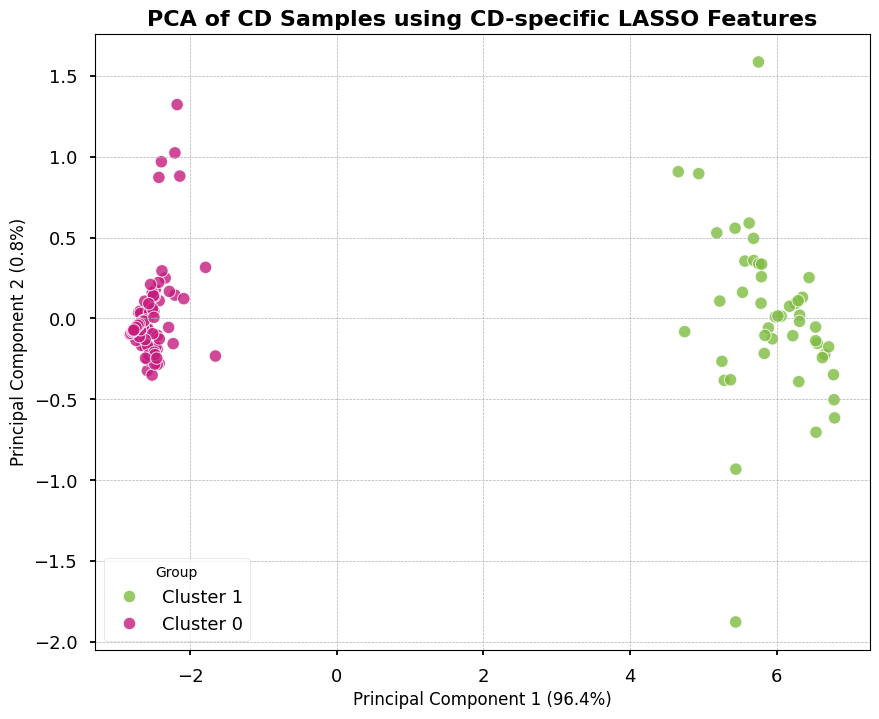

Generating PCA plot: PCA of UC Samples using UC-specific LASSO Features


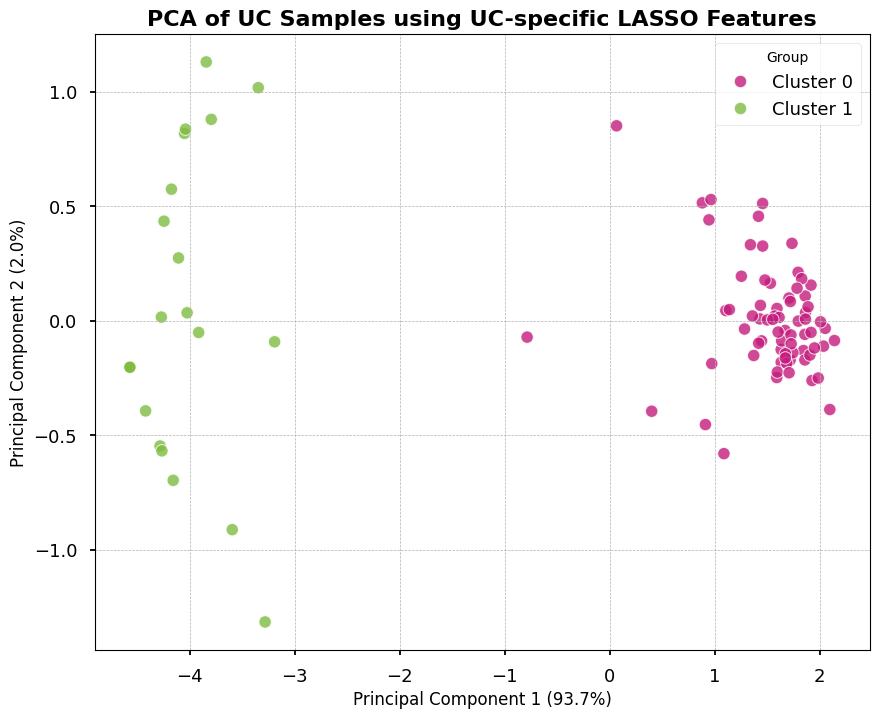


Creating combined PCA using 23 features from both models.
Using 23 common features for combined PCA
Generating PCA plot: PCA of All Samples using All LASSO-selected Features


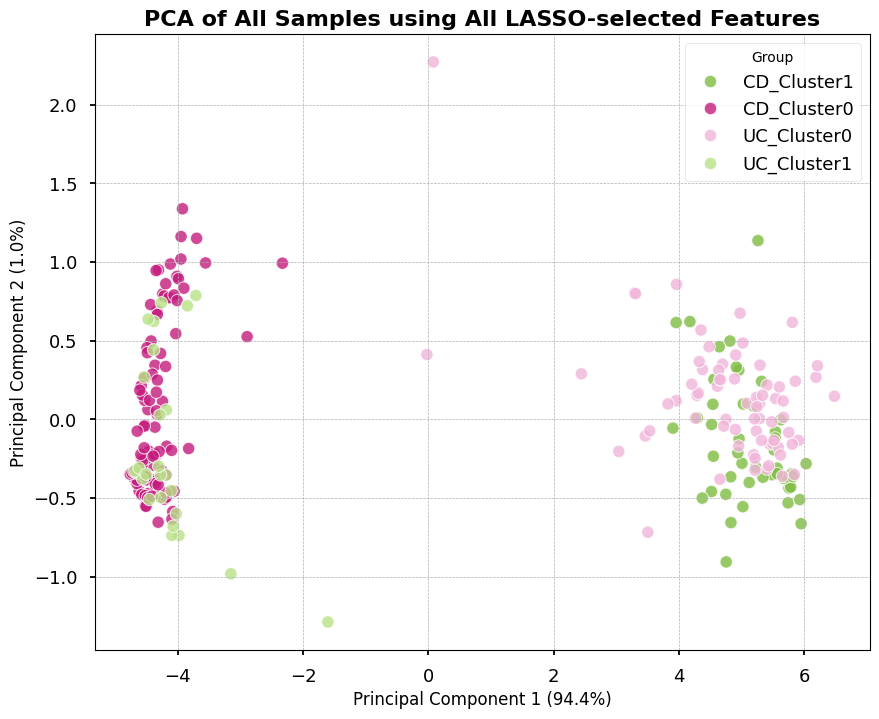


Creating heatmaps and boxplots...
Creating heatmap with 23 common features


<Figure size 2000x1400 with 0 Axes>

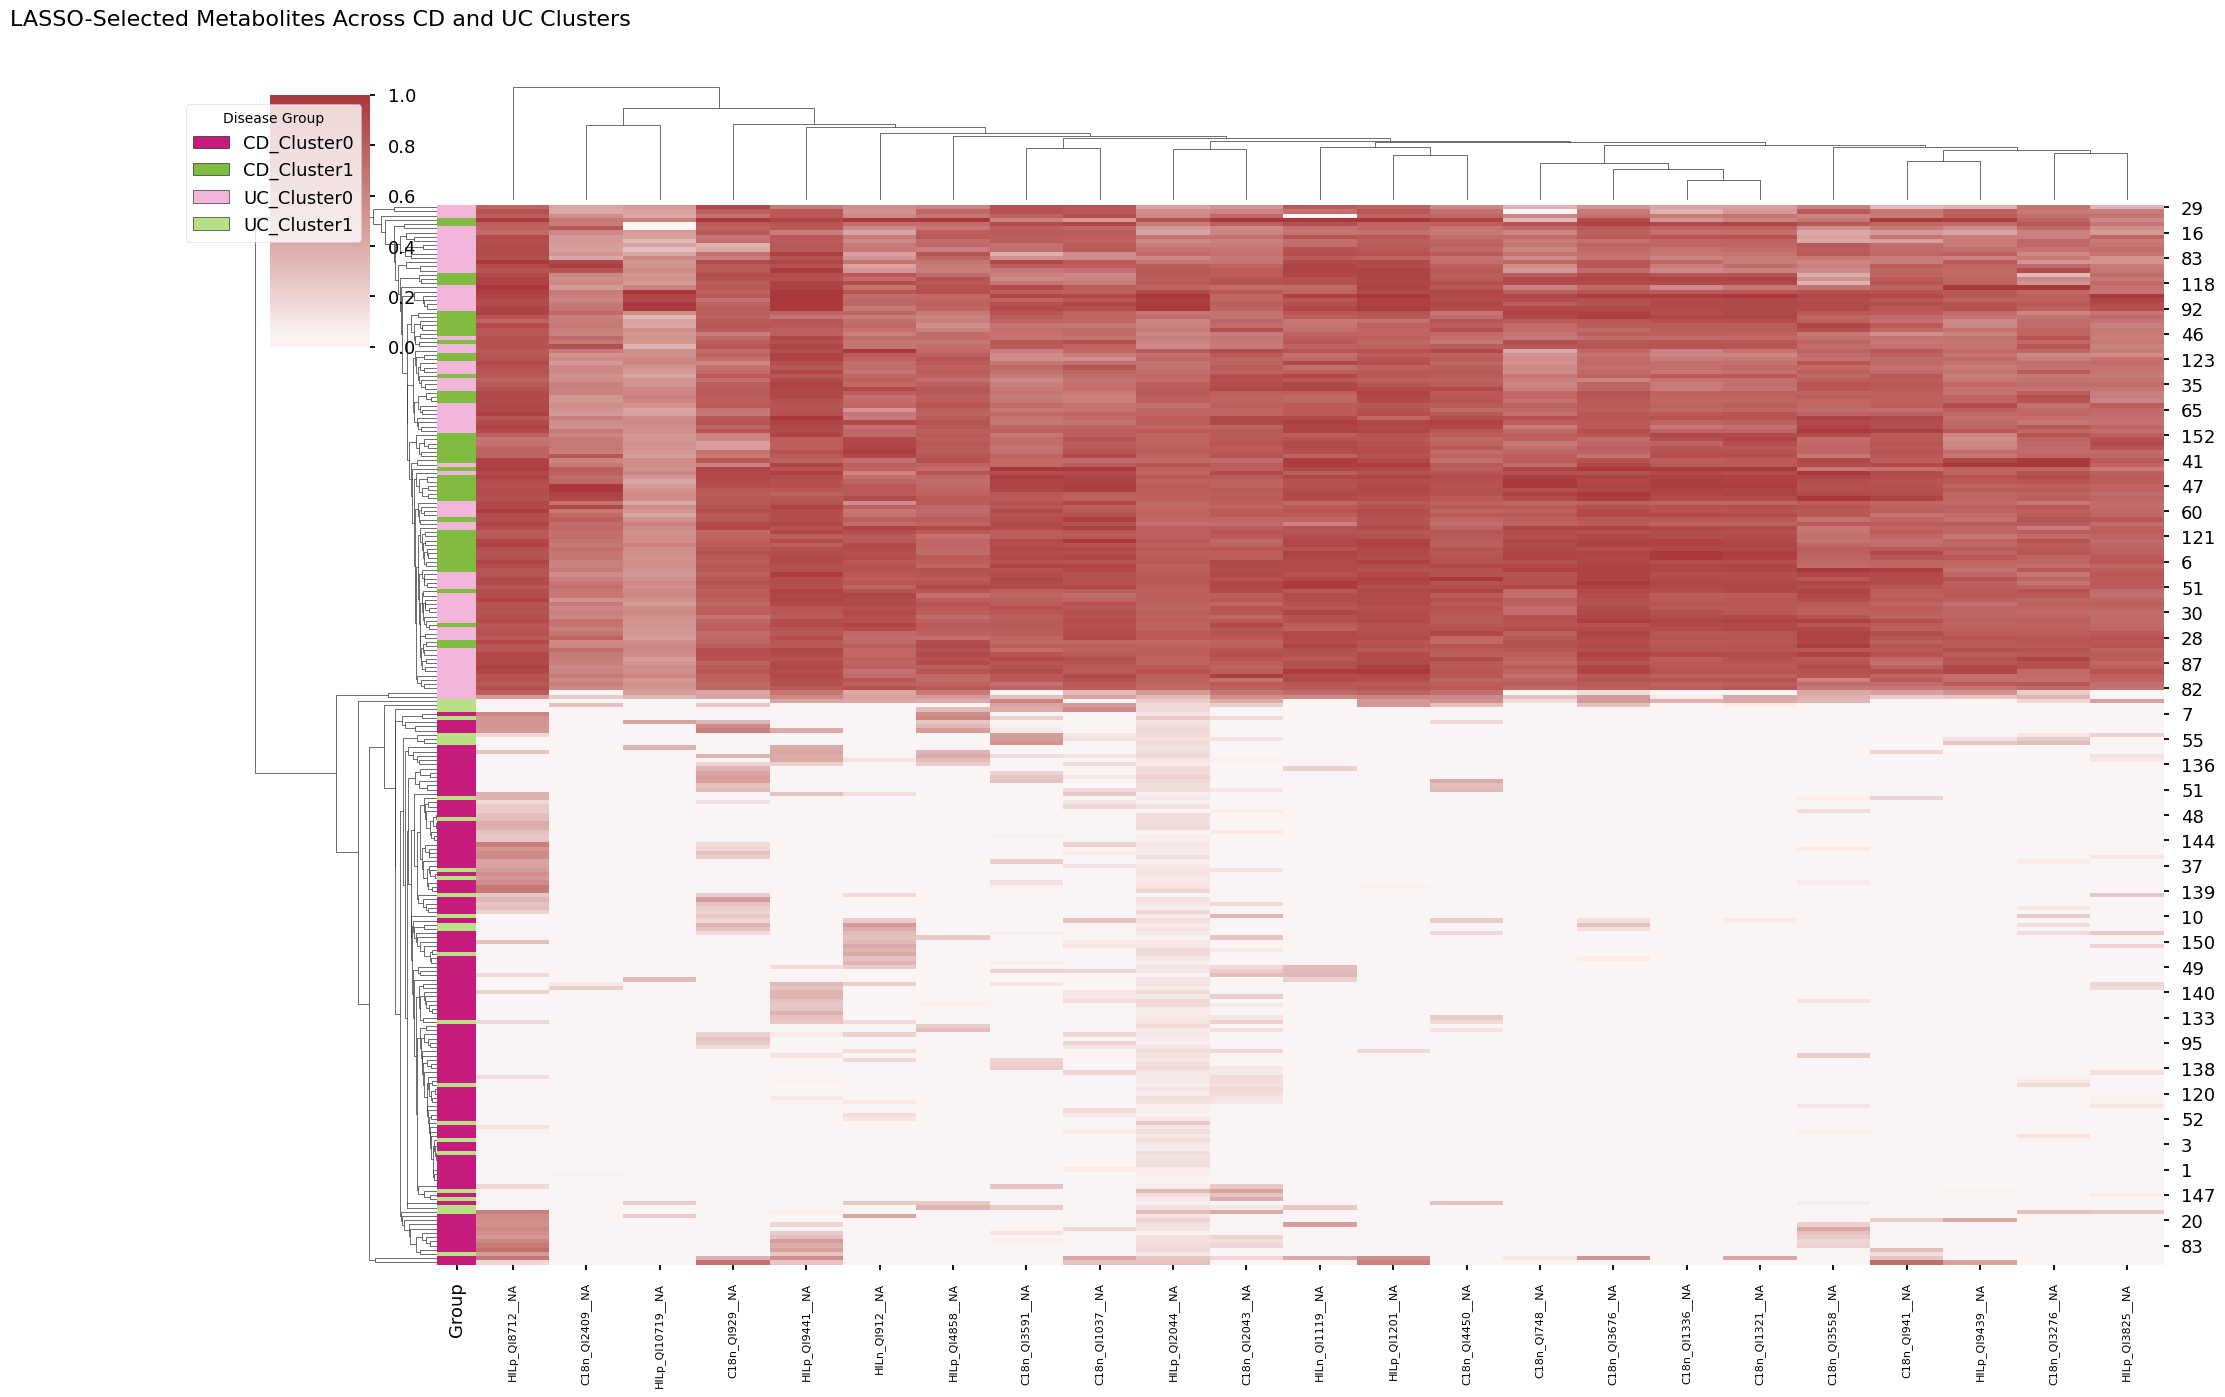

Full feature names saved to: boruta_data/lasso_selected_features_names.tsv
Creating boxplots for 23 features
Creating individual boxplots...
Creating grid plots...
Boxplot creation complete. Files saved to boruta_data/metabolite_boxplots

Analysis Complete! New PCA plots and updated visualizations have been generated.
Generated files:
- PCA plots: boruta_data/CD_LASSO_features_PCA.png, UC_LASSO_features_PCA.png, Combined_LASSO_features_PCA.png
- Heatmap: boruta_data/lasso_selected_metabolites_heatmap.png
- Feature list: boruta_data/lasso_selected_features_names.tsv
- Boxplots: boruta_data/metabolite_boxplots/ (individual and grid plots)
- Statistics: boruta_data/metabolite_boxplots/metabolite_statistics.tsv


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import os
import math
from matplotlib.patches import Patch

# --- Define Custom Colour Palettes using the user-provided list ---
# User-provided colorblind-friendly palette
user_palette = ['#8e0152','#c51b7d','#de77ae','#f1b6da','#fde0ef','#e6f5d0','#b8e186','#7fbc41','#4d9221','#276419']

# Palette for plots with 4 groups, selecting distinct colors
four_color_palette = {
    'CD_Cluster0': user_palette[1], # Dark Pink
    'CD_Cluster1': user_palette[7], # Green
    'UC_Cluster0': user_palette[3], # Light Pink
    'UC_Cluster1': user_palette[6]  # Light Green
}

# Palette for plots with 2 groups
two_color_palette_full = {'Cluster 0': user_palette[1], 'Cluster 1': user_palette[7]}
two_color_palette_short = {'C0': user_palette[1], 'C1': user_palette[7]}


# Load data
print("Loading data...")
cd_clustered_file = 'processing_data/CD_kmeans_2_clustered_data.tsv'
uc_clustered_file = 'processing_data/UC_kmeans_2_clustered_data.tsv'

cd_df = pd.read_csv(cd_clustered_file, sep='\t')
uc_df = pd.read_csv(uc_clustered_file, sep='\t')

print(f"CD data shape: {cd_df.shape}")
print(f"UC data shape: {uc_df.shape}")

# Identify feature columns
cd_feature_cols = [col for col in cd_df.columns if col.startswith(('C18n_', 'C8p_', 'HILn_', 'HILp_'))]
uc_feature_cols = [col for col in uc_df.columns if col.startswith(('C18n_', 'C8p_', 'HILn_', 'HILp_'))]
print(f"Number of CD metabolic features: {len(cd_feature_cols)}")
print(f"Number of UC metabolic features: {len(uc_feature_cols)}")

# Extract cluster labels
cluster_labels_cd = cd_df['KMeans_Cluster'].values
cluster_labels_uc = uc_df['KMeans_Cluster'].values

# Debug data structure
print(f"CD cluster labels unique: {np.unique(cluster_labels_cd)} (type: {type(cluster_labels_cd[0])})")
print(f"UC cluster labels unique: {np.unique(cluster_labels_uc)} (type: {type(cluster_labels_uc[0])})")

# --- FIXED PCA Visualization Function ---
def create_pca_plot(data, features, hue_col, title, filename, palette):
    """
    Creates and saves a PCA plot for the given data and features.
    """
    print(f"Generating PCA plot: {title}")
    
    X = data[features].values
    X_scaled = StandardScaler().fit_transform(X)
    
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)
    pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    
    # FIX: Convert cluster labels to strings to match palette keys
    if hue_col == 'KMeans_Cluster':
        # Convert integer clusters (0, 1) to string format ('Cluster 0', 'Cluster 1')
        pc_df[hue_col] = data[hue_col].map({0: 'Cluster 0', 1: 'Cluster 1'})
    else:
        # For 'Group' column, values are already strings like 'CD_Cluster0'
        pc_df[hue_col] = data[hue_col].values
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='PC1', 
        y='PC2', 
        hue=hue_col, 
        data=pc_df, 
        palette=palette,
        s=80,
        alpha=0.8
    )
    
    plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%})", fontsize=12)
    plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%})", fontsize=12)
    plt.title(title, fontsize=16, weight='bold')
    plt.legend(title='Group')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# --- LASSO feature selection function ---
def lasso_feature_selection(X, y, feature_names, cv=5, max_features=50):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    Cs = np.logspace(-4, 0, 20)
    lasso_cv = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=Cs, cv=cv, random_state=42, max_iter=10000)
    lasso_cv.fit(X_scaled, y)
    best_C = lasso_cv.C_[0]
    print(f"Best C value: {best_C:.6f}")
    coefs = lasso_cv.coef_[0]
    feature_importances = pd.DataFrame({'feature': feature_names, 'coefficient': coefs, 'abs_coefficient': np.abs(coefs)})
    feature_importances = feature_importances.sort_values('abs_coefficient', ascending=False)
    nonzero_features = feature_importances[feature_importances['coefficient'] != 0]
    print(f"LASSO selected {len(nonzero_features)} features with non-zero coefficients")
    if len(nonzero_features) > max_features:
        selected_features = nonzero_features.head(max_features)['feature'].tolist()
        print(f"Taking top {max_features} features by coefficient magnitude")
    else:
        selected_features = nonzero_features['feature'].tolist()
    return selected_features, feature_importances

# --- Heatmap creation function ---
def create_final_heatmap(cd_df, uc_df, features, cluster_labels_cd, cluster_labels_uc):
    common_selected_features = [f for f in features if f in cd_df.columns and f in uc_df.columns]
    print(f"Creating heatmap with {len(common_selected_features)} common features")
    
    cd_subset = cd_df[common_selected_features + ['Sample']].copy()
    cd_subset['Disease'] = 'CD'
    cd_subset['Cluster'] = cluster_labels_cd
    uc_subset = uc_df[common_selected_features + ['Sample']].copy()
    uc_subset['Disease'] = 'UC'
    uc_subset['Cluster'] = cluster_labels_uc
    combined = pd.concat([cd_subset, uc_subset])
    combined['Group'] = combined['Disease'] + '_Cluster' + combined['Cluster'].astype(str)
    
    feature_data = combined[common_selected_features]
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(feature_data)
    scaled_df = pd.DataFrame(scaled_data, columns=common_selected_features, index=combined.index)
    scaled_df['Group'] = combined['Group'].values
    scaled_df['Sample'] = combined['Sample'].values
    annotations = pd.DataFrame({'Group': scaled_df['Group']})
    plt.figure(figsize=(20, 14))
    g = sns.clustermap(
        scaled_df[common_selected_features], 
        row_colors=annotations.replace({'Group': four_color_palette}),
        figsize=(20, 14), 
        cmap='vlag', 
        center=0, 
        standard_scale=1, 
        dendrogram_ratio=0.1, 
        colors_ratio=0.02, 
        xticklabels=1
    )
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center', fontsize=8)
    handles = [plt.Rectangle((0,0), 1, 1, color=color, ec='black') for color in four_color_palette.values()]
    plt.legend(handles, four_color_palette.keys(), title='Disease Group', bbox_to_anchor=(1, 1), loc='upper right')
    plt.title('LASSO-Selected Metabolites Across CD and UC Clusters', fontsize=16, pad=50)
    plt.savefig('boruta_data/lasso_selected_metabolites_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    feature_table = pd.DataFrame({'Feature': common_selected_features})
    feature_table.to_csv('boruta_data/lasso_selected_features_names.tsv', sep='\t', index=False)
    print(f"Full feature names saved to: boruta_data/lasso_selected_features_names.tsv")
    return common_selected_features

# --- COMPLETELY FIXED Boxplot creation function ---
def create_metabolite_boxplots(cd_df, uc_df, features, cluster_labels_cd, cluster_labels_uc, output_dir, grid_size=16):
    common_selected_features = [f for f in features if f in cd_df.columns and f in uc_df.columns]
    print(f"Creating boxplots for {len(common_selected_features)} features")
    
    os.makedirs(output_dir, exist_ok=True)
    stats_results = []
    
    # Calculate statistics for each feature
    for feature in common_selected_features:
        cd_cluster0 = cd_df.loc[cluster_labels_cd == 0, feature]
        cd_cluster1 = cd_df.loc[cluster_labels_cd == 1, feature]
        cd_ttest = stats.ttest_ind(cd_cluster0, cd_cluster1, equal_var=False)
        
        uc_cluster0 = uc_df.loc[cluster_labels_uc == 0, feature]
        uc_cluster1 = uc_df.loc[cluster_labels_uc == 1, feature]
        uc_ttest = stats.ttest_ind(uc_cluster0, uc_cluster1, equal_var=False)
        
        stats_results.append({
            'feature': feature,
            'cd_pval': cd_ttest.pvalue, 
            'cd_fold_change': cd_cluster1.mean() - cd_cluster0.mean(),
            'uc_pval': uc_ttest.pvalue, 
            'uc_fold_change': uc_cluster1.mean() - uc_cluster0.mean()
        })
    
    stats_df = pd.DataFrame(stats_results)
    stats_df['cd_fdr'] = multipletests(stats_df['cd_pval'], method='fdr_bh')[1]
    stats_df['uc_fdr'] = multipletests(stats_df['uc_pval'], method='fdr_bh')[1]
    stats_df.to_csv(f'{output_dir}/metabolite_statistics.tsv', sep='\t', index=False)
    
    # Individual box plots
    print("Creating individual boxplots...")
    for i, feature in enumerate(common_selected_features):
        # Get current feature data (recalculated to avoid scope issues)
        cd_cluster0_data = cd_df.loc[cluster_labels_cd == 0, feature]
        cd_cluster1_data = cd_df.loc[cluster_labels_cd == 1, feature]
        uc_cluster0_data = uc_df.loc[cluster_labels_uc == 0, feature]
        uc_cluster1_data = uc_df.loc[cluster_labels_uc == 1, feature]
        
        cd_pval, uc_pval = stats_df.loc[i, 'cd_fdr'], stats_df.loc[i, 'uc_fdr']
        
        plt.figure(figsize=(10, 6))
        
        # Create correctly formatted data with string cluster labels
        cd_data = pd.DataFrame({
            'Disease': 'CD', 
            'Cluster': ['Cluster 0'] * len(cd_cluster0_data) + ['Cluster 1'] * len(cd_cluster1_data), 
            'Value': list(cd_cluster0_data) + list(cd_cluster1_data)
        })
        
        uc_data = pd.DataFrame({
            'Disease': 'UC', 
            'Cluster': ['Cluster 0'] * len(uc_cluster0_data) + ['Cluster 1'] * len(uc_cluster1_data), 
            'Value': list(uc_cluster0_data) + list(uc_cluster1_data)
        })
        
        combined_data = pd.concat([cd_data, uc_data])

        sns.boxplot(x='Disease', y='Value', hue='Cluster', data=combined_data, palette=two_color_palette_full)
        
        # Add significance annotations
        y_max, y_min = combined_data['Value'].max(), combined_data['Value'].min()
        y_range = y_max - y_min
        cd_stars = '***' if cd_pval < 0.001 else '**' if cd_pval < 0.01 else '*' if cd_pval < 0.05 else 'ns'
        uc_stars = '***' if uc_pval < 0.001 else '**' if uc_pval < 0.01 else '*' if uc_pval < 0.05 else 'ns'
        plt.text(0, y_max + y_range * 0.05, cd_stars, ha='center', fontsize=14)
        plt.text(1, y_max + y_range * 0.05, uc_stars, ha='center', fontsize=14)
        
        plt.title(feature, fontsize=12)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/{i+1:02d}_{feature.replace("/", "_").replace(":", "_")}.png', dpi=300)
        plt.close()

    # Create grid figures
    print("Creating grid plots...")
    num_grids = math.ceil(len(common_selected_features) / grid_size)
    
    for grid_num in range(num_grids):
        start_idx = grid_num * grid_size
        end_idx = min(start_idx + grid_size, len(common_selected_features))
        grid_features = common_selected_features[start_idx:end_idx]
        
        # Determine grid layout
        nrows, ncols = (4, 4) if len(grid_features) > 9 else ((3, 3) if len(grid_features) > 4 else (2, 2))
        
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))
        axes = axes.flatten()
        
        for i, feature in enumerate(grid_features):
            ax = axes[i]
            
            # Get data for current feature (recalculated to avoid scope issues)
            cd_cluster0_grid = cd_df.loc[cluster_labels_cd == 0, feature]
            cd_cluster1_grid = cd_df.loc[cluster_labels_cd == 1, feature]
            uc_cluster0_grid = uc_df.loc[cluster_labels_uc == 0, feature]
            uc_cluster1_grid = uc_df.loc[cluster_labels_uc == 1, feature]
            
            # Create data with short cluster labels for grid plots
            cd_data = pd.DataFrame({
                'Disease': 'CD', 
                'Cluster': ['C0'] * len(cd_cluster0_grid) + ['C1'] * len(cd_cluster1_grid), 
                'Value': list(cd_cluster0_grid) + list(cd_cluster1_grid)
            })
            
            uc_data = pd.DataFrame({
                'Disease': 'UC', 
                'Cluster': ['C0'] * len(uc_cluster0_grid) + ['C1'] * len(uc_cluster1_grid), 
                'Value': list(uc_cluster0_grid) + list(uc_cluster1_grid)
            })
            
            combined_data = pd.concat([cd_data, uc_data])
            
            sns.boxplot(x='Disease', y='Value', hue='Cluster', data=combined_data, 
                       palette=two_color_palette_short, ax=ax)
            
            # Legend (only show on first plot)
            if i > 0: 
                if ax.get_legend():
                    ax.get_legend().remove()
            else: 
                ax.legend(title="Cluster", loc='upper right')
            
            ax.set_title(feature, fontsize=8)
        
        # Hide unused subplots
        for j in range(len(grid_features), nrows * ncols): 
            axes[j].axis('off')
        
        plt.tight_layout()
        # plt.savefig(f'{output_dir}/grid_{grid_num + 1:02d}.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    print(f"Boxplot creation complete. Files saved to {output_dir}")
    return stats_df

print("\n" + "="*50)
print("LASSO Feature Selection for CD and UC")
print("="*50)

# Apply LASSO to CD and UC data
X_cd = cd_df[cd_feature_cols].values
y_cd = cluster_labels_cd
cd_lasso_features, cd_feature_importances = lasso_feature_selection(X_cd, y_cd, cd_feature_cols)
print(f"CD LASSO selected {len(cd_lasso_features)} features")

X_uc = uc_df[uc_feature_cols].values
y_uc = cluster_labels_uc
uc_lasso_features, uc_feature_importances = lasso_feature_selection(X_uc, y_uc, uc_feature_cols)
print(f"UC LASSO selected {len(uc_lasso_features)} features")

# --- PCA VISUALIZATION ---
print("\n" + "="*50)
print("Creating PCA plots...")
print("="*50)

# 1. CD PCA Plot
create_pca_plot(
    data=cd_df, features=cd_lasso_features, hue_col='KMeans_Cluster',
    title='PCA of CD Samples using CD-specific LASSO Features',
    filename='boruta_data/CD_LASSO_features_PCA.png', palette=two_color_palette_full
)

# 2. UC PCA Plot
create_pca_plot(
    data=uc_df, features=uc_lasso_features, hue_col='KMeans_Cluster',
    title='PCA of UC Samples using UC-specific LASSO Features',
    filename='boruta_data/UC_LASSO_features_PCA.png', palette=two_color_palette_full
)

# 3. Combined Overlapping PCA Plot
combined_features = list(set(cd_lasso_features) | set(uc_lasso_features))
print(f"\nCreating combined PCA using {len(combined_features)} features from both models.")

cd_for_pca = cd_df[['Sample', 'KMeans_Cluster'] + [f for f in combined_features if f in cd_df.columns]].copy()
cd_for_pca['Group'] = 'CD_Cluster' + cd_for_pca['KMeans_Cluster'].astype(str)

uc_for_pca = uc_df[['Sample', 'KMeans_Cluster'] + [f for f in combined_features if f in uc_df.columns]].copy()
uc_for_pca['Group'] = 'UC_Cluster' + uc_for_pca['KMeans_Cluster'].astype(str)

# Only use features that exist in both datasets for the combined PCA
common_features_for_pca = [f for f in combined_features if f in cd_df.columns and f in uc_df.columns]
print(f"Using {len(common_features_for_pca)} common features for combined PCA")

# Recreate DataFrames with only common features
cd_for_pca = cd_df[['Sample', 'KMeans_Cluster'] + common_features_for_pca].copy()
cd_for_pca['Group'] = 'CD_Cluster' + cd_for_pca['KMeans_Cluster'].astype(str)

uc_for_pca = uc_df[['Sample', 'KMeans_Cluster'] + common_features_for_pca].copy()
uc_for_pca['Group'] = 'UC_Cluster' + uc_for_pca['KMeans_Cluster'].astype(str)

combined_df_pca = pd.concat([cd_for_pca, uc_for_pca], ignore_index=True)

create_pca_plot(
    data=combined_df_pca, features=common_features_for_pca, hue_col='Group',
    title='PCA of All Samples using All LASSO-selected Features',
    filename='boruta_data/Combined_LASSO_features_PCA.png', palette=four_color_palette
)

# --- Heatmap and Boxplot Creation ---
print("\n" + "="*50)
print("Creating heatmaps and boxplots...")
print("="*50)

common_selected_features = create_final_heatmap(cd_df, uc_df, combined_features, cluster_labels_cd, cluster_labels_uc)

boxplot_dir = 'boruta_data/metabolite_boxplots'
stats_results = create_metabolite_boxplots(
    cd_df, uc_df, common_selected_features, 
    cluster_labels_cd, cluster_labels_uc, boxplot_dir
)

print("\nAnalysis Complete! New PCA plots and updated visualizations have been generated.")
print(f"Generated files:")
print("- PCA plots: boruta_data/CD_LASSO_features_PCA.png, UC_LASSO_features_PCA.png, Combined_LASSO_features_PCA.png")
print("- Heatmap: boruta_data/lasso_selected_metabolites_heatmap.png")
print("- Feature list: boruta_data/lasso_selected_features_names.tsv")
print(f"- Boxplots: {boxplot_dir}/ (individual and grid plots)")
print(f"- Statistics: {boxplot_dir}/metabolite_statistics.tsv")


Creating Directional Consistency Analysis...
Creating directional consistency analysis...


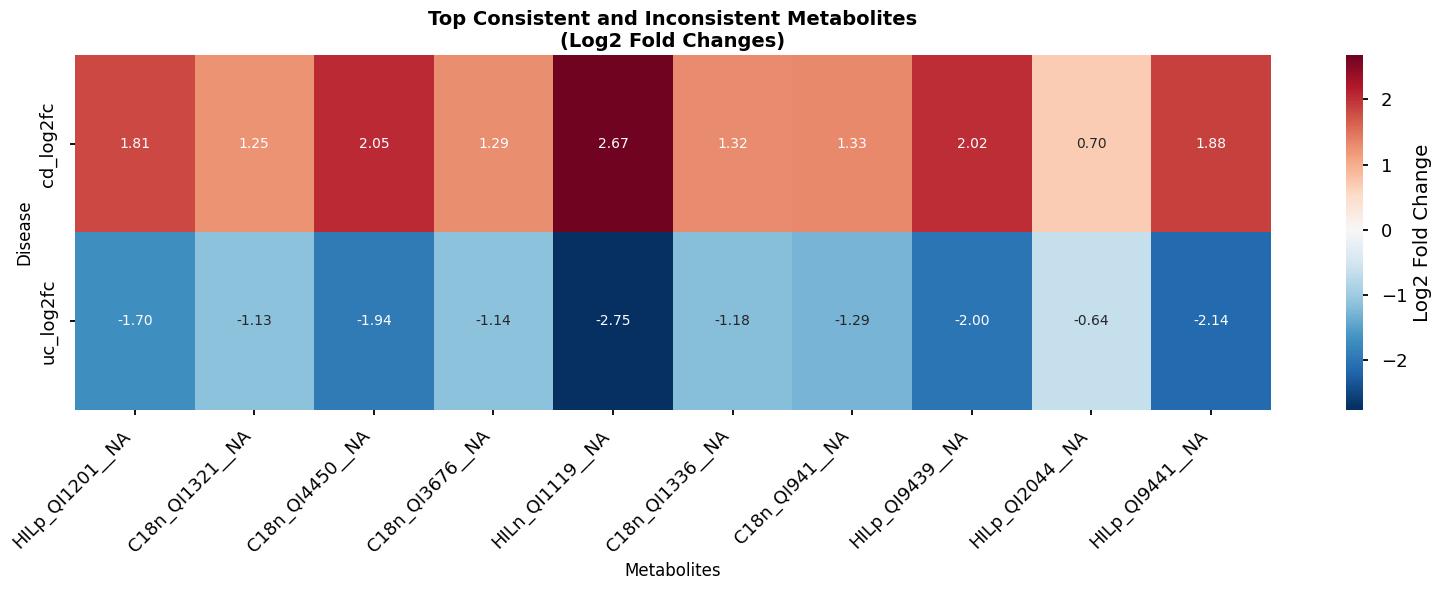


DIRECTIONAL CONSISTENCY ANALYSIS SUMMARY
Total metabolites analyzed: 23
Metabolites with same direction in both diseases: 0
Metabolites with opposite directions: 23

Significance category breakdown:
  Opposite Directions: 23 (100.0%)

Top 5 most inconsistent metabolites (opposite directions):
  1. HILp_QI1201__NA
     CD log2FC: 1.807, UC log2FC: -1.700
  2. C18n_QI1321__NA
     CD log2FC: 1.252, UC log2FC: -1.131
  3. C18n_QI4450__NA
     CD log2FC: 2.045, UC log2FC: -1.942
  4. C18n_QI3676__NA
     CD log2FC: 1.285, UC log2FC: -1.139
  5. HILn_QI1119__NA
     CD log2FC: 2.673, UC log2FC: -2.753

Creating Network Analysis...
Creating metabolite network analysis...


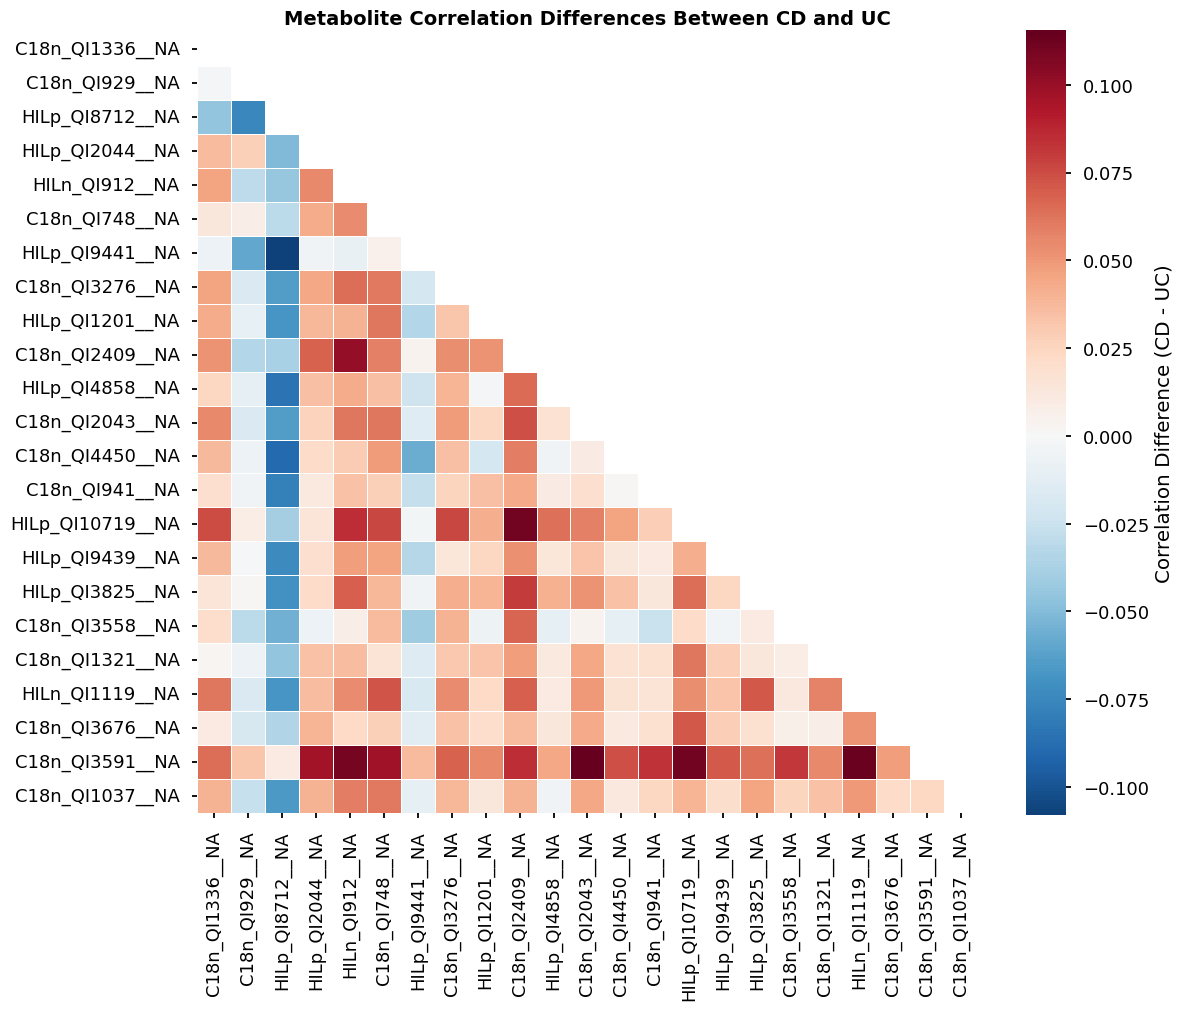


Analysis Complete! All visualizations have been generated.


In [25]:
def create_directional_consistency_analysis(cd_df, uc_df, features, cluster_labels_cd, cluster_labels_uc, output_dir):

    """
    Creates comprehensive directional consistency analysis visualizations.
    This shows how metabolites change direction (up/down) between clusters in CD vs UC.
    """
    print("Creating directional consistency analysis...")
    
    common_features = [f for f in features if f in cd_df.columns and f in uc_df.columns]
    os.makedirs(output_dir, exist_ok=True)
    
    # Calculate fold changes and effect sizes for each metabolite
    consistency_data = []
    
    for feature in common_features:
        # CD analysis
        cd_cluster0 = cd_df.loc[cluster_labels_cd == 0, feature]
        cd_cluster1 = cd_df.loc[cluster_labels_cd == 1, feature]
        cd_fold_change = np.log2((cd_cluster1.mean() + 1) / (cd_cluster0.mean() + 1))  # Log2 fold change
        cd_effect_size = (cd_cluster1.mean() - cd_cluster0.mean()) / np.sqrt(((cd_cluster1.std()**2 + cd_cluster0.std()**2) / 2))  # Cohen's d
        cd_pval = stats.ttest_ind(cd_cluster0, cd_cluster1, equal_var=False).pvalue
        
        # UC analysis
        uc_cluster0 = uc_df.loc[cluster_labels_uc == 0, feature]
        uc_cluster1 = uc_df.loc[cluster_labels_uc == 1, feature]
        uc_fold_change = np.log2((uc_cluster1.mean() + 1) / (uc_cluster0.mean() + 1))  # Log2 fold change
        uc_effect_size = (uc_cluster1.mean() - uc_cluster0.mean()) / np.sqrt(((uc_cluster1.std()**2 + uc_cluster0.std()**2) / 2))  # Cohen's d
        uc_pval = stats.ttest_ind(uc_cluster0, uc_cluster1, equal_var=False).pvalue
        
        # Determine consistency
        same_direction = (cd_fold_change * uc_fold_change) > 0
        consistency_score = np.corrcoef([cd_fold_change], [uc_fold_change])[0,1] if not np.isnan([cd_fold_change, uc_fold_change]).any() else 0
        
        consistency_data.append({
            'feature': feature,
            'cd_log2fc': cd_fold_change,
            'uc_log2fc': uc_fold_change,
            'cd_effect_size': cd_effect_size,
            'uc_effect_size': uc_effect_size,
            'cd_pval': cd_pval,
            'uc_pval': uc_pval,
            'same_direction': same_direction,
            'consistency_score': consistency_score,
            'avg_effect_size': (abs(cd_effect_size) + abs(uc_effect_size)) / 2
        })
    
    consistency_df = pd.DataFrame(consistency_data)
    
    # Apply FDR correction
    consistency_df['cd_fdr'] = multipletests(consistency_df['cd_pval'], method='fdr_bh')[1]
    consistency_df['uc_fdr'] = multipletests(consistency_df['uc_pval'], method='fdr_bh')[1]
    
    # Define significance categories
    def get_significance_category(cd_fdr, uc_fdr, same_dir):
        if cd_fdr < 0.05 and uc_fdr < 0.05:
            return "Both Significant" if same_dir else "Opposite Directions"
        elif cd_fdr < 0.05:
            return "CD Only"
        elif uc_fdr < 0.05:
            return "UC Only"
        else:
            return "Non-significant"
    
    consistency_df['significance_category'] = consistency_df.apply(
        lambda row: get_significance_category(row['cd_fdr'], row['uc_fdr'], row['same_direction']), axis=1
    )
    
    consistency_df.to_csv(f'{output_dir}/directional_consistency_analysis.tsv', sep='\t', index=False)
    

# 4. Top Consistent and Inconsistent Metabolites
    # Most consistent (same direction, both significant)
    consistent_metabolites = consistency_df[
        (consistency_df['significance_category'] == 'Both Significant') & 
        (consistency_df['same_direction'] == True)
    ].nlargest(10, 'avg_effect_size')
    
    # Most inconsistent (opposite directions, both significant)
    inconsistent_metabolites = consistency_df[
        consistency_df['significance_category'] == 'Opposite Directions'
    ].nlargest(10, 'avg_effect_size')
    
    # Create heatmap of top consistent/inconsistent metabolites
    if len(consistent_metabolites) > 0 or len(inconsistent_metabolites) > 0:
        top_metabolites = pd.concat([consistent_metabolites, inconsistent_metabolites])
        
        if len(top_metabolites) > 0:
            heatmap_data = top_metabolites[['cd_log2fc', 'uc_log2fc']].T
            heatmap_data.columns = [f"{row['feature'][:30]}..." if len(row['feature']) > 30 else row['feature'] 
                                   for _, row in top_metabolites.iterrows()]
            plt.figure(figsize=(16, 6))
            sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                       cbar_kws={'label': 'Log2 Fold Change'})
            plt.title('Top Consistent and Inconsistent Metabolites\n(Log2 Fold Changes)', fontsize=14, weight='bold')
            plt.ylabel('Disease', fontsize=12)
            plt.xlabel('Metabolites', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            plt.close()

        # 3. Summary Bar Chart
    category_counts = consistency_df['significance_category'].value_counts()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("DIRECTIONAL CONSISTENCY ANALYSIS SUMMARY")
    print("="*60)
    print(f"Total metabolites analyzed: {len(consistency_df)}")
    print(f"Metabolites with same direction in both diseases: {sum(consistency_df['same_direction'])}")
    print(f"Metabolites with opposite directions: {sum(~consistency_df['same_direction'])}")
    print("\nSignificance category breakdown:")
    for category, count in category_counts.items():
        print(f"  {category}: {count} ({count/len(consistency_df)*100:.1f}%)")
    
    if len(consistent_metabolites) > 0:
        print(f"\nTop 5 most consistent metabolites:")
        for i, (_, row) in enumerate(consistent_metabolites.head().iterrows()):
            print(f"  {i+1}. {row['feature'][:50]}{'...' if len(row['feature']) > 50 else ''}")
            print(f"     CD log2FC: {row['cd_log2fc']:.3f}, UC log2FC: {row['uc_log2fc']:.3f}")
    
    if len(inconsistent_metabolites) > 0:
        print(f"\nTop 5 most inconsistent metabolites (opposite directions):")
        for i, (_, row) in enumerate(inconsistent_metabolites.head().iterrows()):
            print(f"  {i+1}. {row['feature'][:50]}{'...' if len(row['feature']) > 50 else ''}")
            print(f"     CD log2FC: {row['cd_log2fc']:.3f}, UC log2FC: {row['uc_log2fc']:.3f}")
    
    return consistency_df


# --- Network Analysis Function  ---
def create_metabolite_network_analysis(cd_df, uc_df, features, cluster_labels_cd, cluster_labels_uc, output_dir):
    """
    Creates a correlation network analysis showing metabolite relationships.
    """
    print("Creating metabolite network analysis...")
    
    common_features = [f for f in features if f in cd_df.columns and f in uc_df.columns]
    
    # Calculate correlations within each disease
    cd_corr = cd_df[common_features].corr()
    uc_corr = uc_df[common_features].corr()
    
    # Create correlation difference heatmap
    corr_diff = cd_corr - uc_corr
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_diff, dtype=bool))  # Hide upper triangle
    sns.heatmap(corr_diff, mask=mask, annot=False, cmap='RdBu_r', center=0,
               square=True, linewidths=0.5, cbar_kws={'label': 'Correlation Difference (CD - UC)'})
    plt.title('Metabolite Correlation Differences Between CD and UC', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return cd_corr, uc_corr, corr_diff


# Directional consistency analysis
print("\n" + "="*50)
print("Creating Directional Consistency Analysis...")
print("="*50)

consistency_output_dir = 'boruta_data/directional_consistency'
consistency_results = create_directional_consistency_analysis(
    cd_df, uc_df, common_selected_features, 
    cluster_labels_cd, cluster_labels_uc, consistency_output_dir
)

# Optional: Add network analysis
print("\n" + "="*50)
print("Creating Network Analysis...")
print("="*50)

network_output_dir = 'boruta_data/network_analysis'
os.makedirs(network_output_dir, exist_ok=True)
cd_corr, uc_corr, corr_diff = create_metabolite_network_analysis(
    cd_df, uc_df, common_selected_features,
    cluster_labels_cd, cluster_labels_uc, network_output_dir
)

print("\nAnalysis Complete! All visualizations have been generated.")


Creating LASSO Coefficient Comparison Plot...


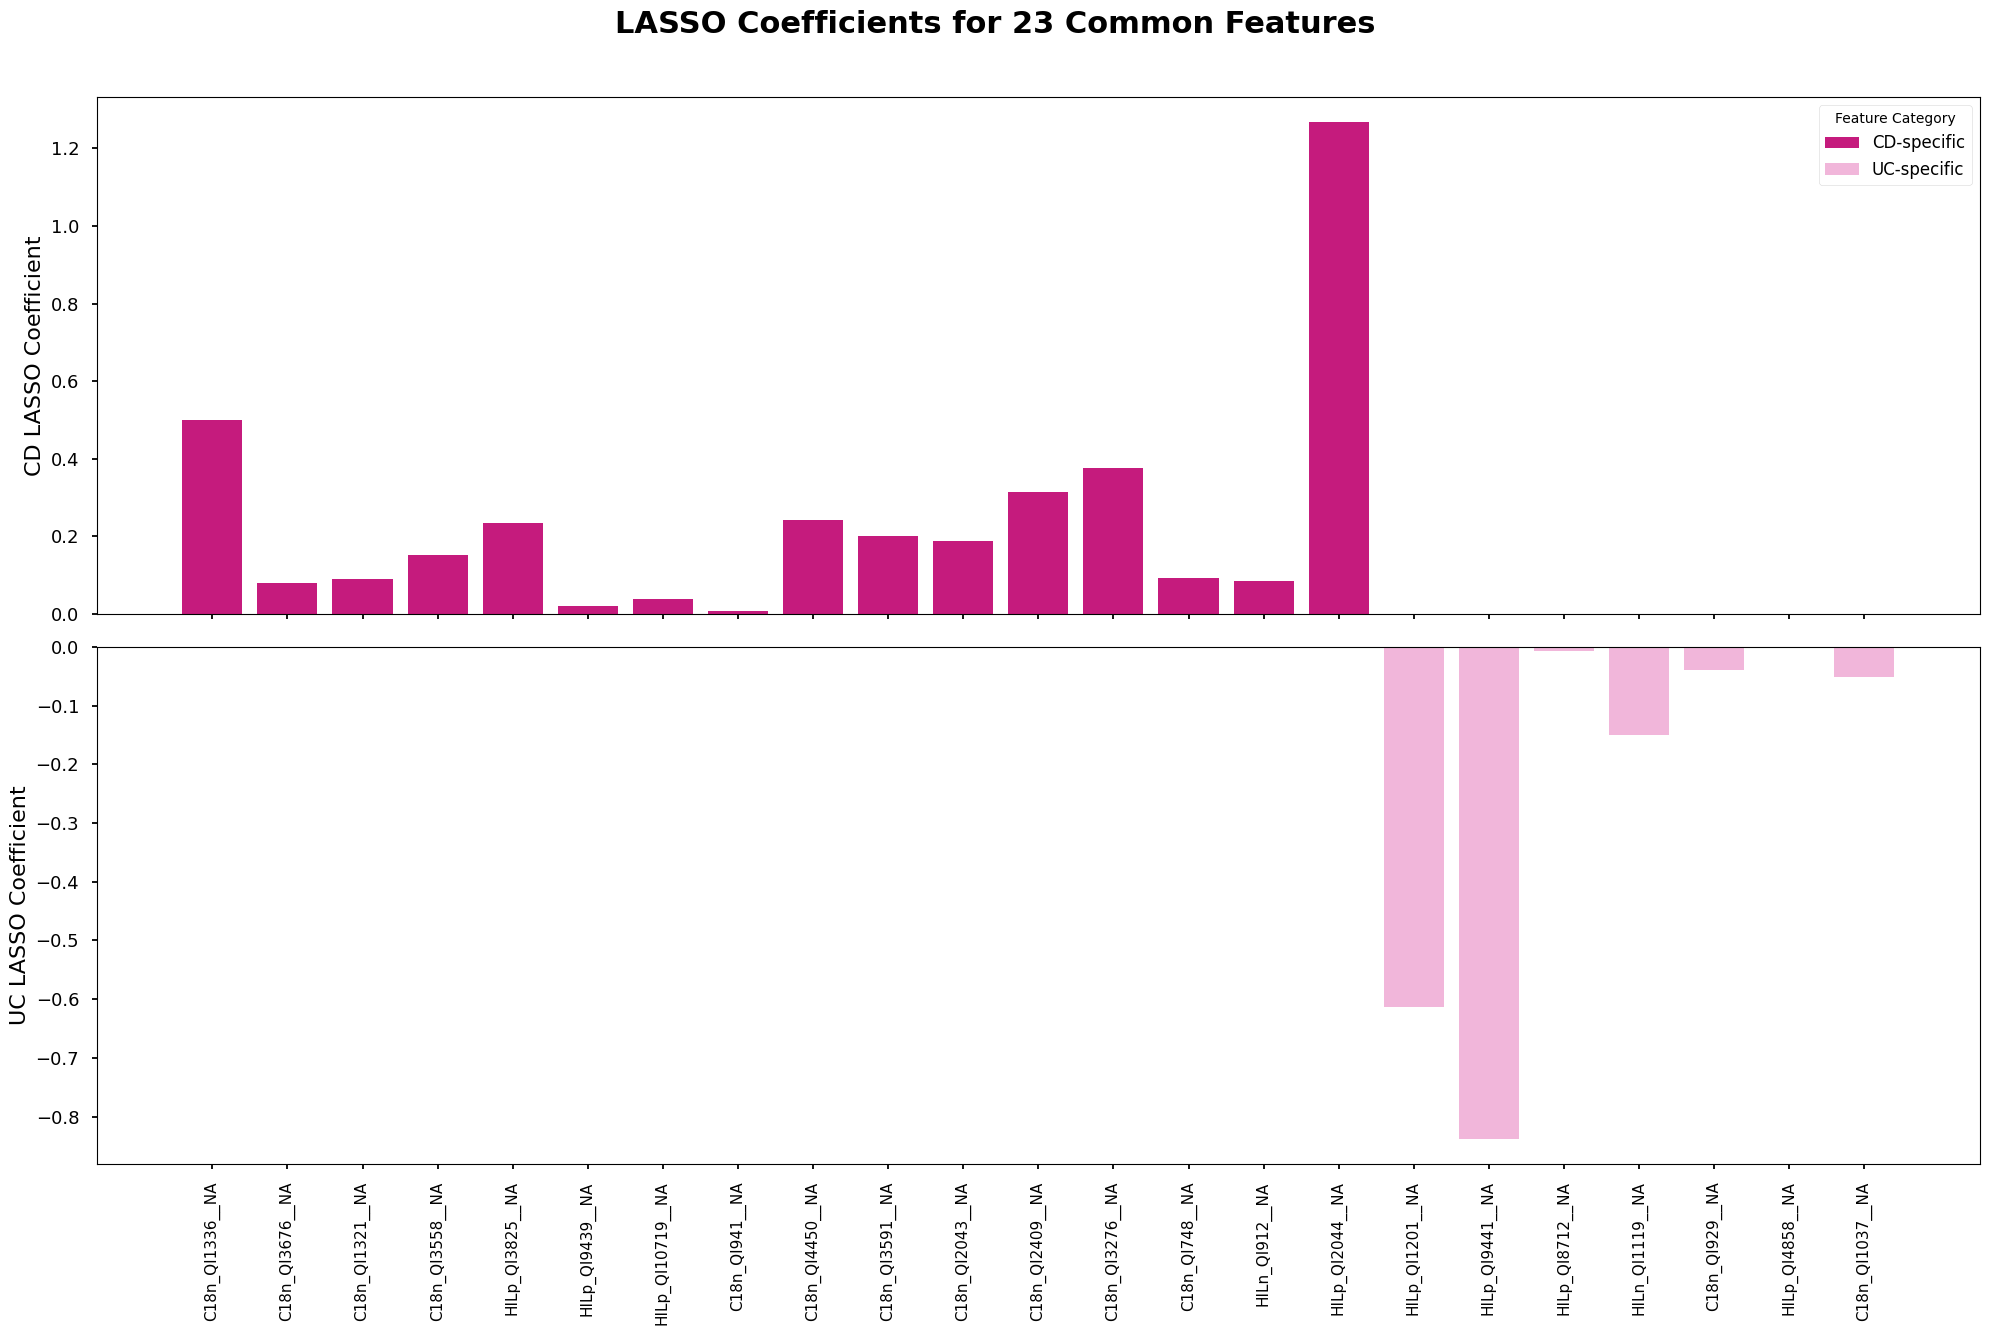


Generated LASSO coefficient comparison plot: boruta_data/lasso_coefficient_comparison.png


In [35]:
# --- LASSO Coefficient Comparison Plot ---
print("\n" + "="*50)
print("Creating LASSO Coefficient Comparison Plot...")
print("="*50)

# Create sets for efficient lookup
cd_lasso_set = set(cd_lasso_features)
uc_lasso_set = set(uc_lasso_features)

# Categorize each of the common features based on LASSO selection and coefficient direction
feature_categories = []
for feature in common_selected_features:
    is_cd_selected = feature in cd_lasso_set
    is_uc_selected = feature in uc_lasso_set

    # Get coefficients; will be 0 if not selected by that model
    cd_coef_row = cd_feature_importances[cd_feature_importances['feature'] == feature]
    uc_coef_row = uc_feature_importances[uc_feature_importances['feature'] == feature]
    cd_coef = cd_coef_row['coefficient'].values[0] if not cd_coef_row.empty else 0
    uc_coef = uc_coef_row['coefficient'].values[0] if not uc_coef_row.empty else 0

    # Determine the category for coloring the plot
    category = 'Unknown' # Default
    if is_cd_selected and is_uc_selected:
        # Selected in both, check direction
        if np.sign(cd_coef) == np.sign(uc_coef):
            category = 'Both (same direction)'
        else:
            category = 'Inverse'
    elif is_cd_selected:
        category = 'CD-specific'
    elif is_uc_selected:
        category = 'UC-specific'
    
    feature_categories.append({
        'feature': feature,
        'category': category,
        'cd_coefficient': cd_coef,
        'uc_coefficient': uc_coef,
    })

feature_categories_df = pd.DataFrame(feature_categories)

# --- Create the Bar Plot Visualization ---

# Define colors for each category
category_colors = {
    'CD-specific': '#c51b7d',            # Pink
    'UC-specific': '#f1b6da',          # Light Pink
    'Inverse': '#4d9221',                # Green
    'Both (same direction)': '#8e0152',  # Dark Pink/Purple
    'Unknown': 'gray'
}

# Sort features by category to group them visually in the plot
feature_categories_df_sorted = feature_categories_df.sort_values('category')
x_positions = np.arange(len(feature_categories_df_sorted))

# Create a figure with two subplots (one for CD, one for UC)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 14), sharex=True)
fig.suptitle(f'LASSO Coefficients for {len(common_selected_features)} Common Features', fontsize=22, weight='bold')

# Plot CD coefficients on the top subplot
ax1.bar(x_positions, feature_categories_df_sorted['cd_coefficient'], 
        color=[category_colors.get(cat, 'gray') for cat in feature_categories_df_sorted['category']])
ax1.set_ylabel('CD LASSO Coefficient', fontsize=16)
# ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
# ax1.grid(axis='y', linestyle='--', alpha=1)

# Plot UC coefficients on the bottom subplot
ax2.bar(x_positions, feature_categories_df_sorted['uc_coefficient'], 
        color=[category_colors.get(cat, 'gray') for cat in feature_categories_df_sorted['category']])
ax2.set_ylabel('UC LASSO Coefficient', fontsize=16)
# ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
# ax2.grid(axis='y', linestyle='--', alpha=1)

# Set the feature names as x-axis labels on the bottom plot
plt.xticks(x_positions, feature_categories_df_sorted['feature'], rotation=90, ha='center', fontsize=11)

legend_elements = [Patch(facecolor=color, label=category) 
                   for category, color in category_colors.items() if category in feature_categories_df_sorted['category'].unique()]
ax1.legend(handles=legend_elements, loc='upper right', title="Feature Category", fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig('boruta_data/lasso_coefficient_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"\nGenerated LASSO coefficient comparison plot: boruta_data/lasso_coefficient_comparison.png")